# Purpose:
- Try identifying the source of clustering index variation from neuronal activities
    - Number of fit neurons, touch neurons, tuned neurons, explained variance, etc.
    - (behavior features do not seem to affect- cf., 240421_clustering_index_from_subsampled.ipynb)


In [1]:
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.style.use('default')
import xarray as xr
from utils import lda_angle_discrim as lad
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.optimize import linear_sum_assignment
import utils.lda_angle_discrim as lda_angle
import utils.logistic_regression_angle as logireg_angle
import utils.clustering_index as ci
import pickle
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import socket
host_name = socket.gethostname()
if host_name == 'HNB228-LABPC6':
    base_dir = Path(r'D:\JK\h5')
elif host_name == 'hnb228-jinho':
    # base_dir = Path(r'E:\TPM\JK\h5')
    base_dir = Path(r'C:\JK')
else:
    raise('Incorrect computer')

results_dir = base_dir / 'results'
# wf_dir = results_dir / 'touch_whisker_features'
# b_dir = Path(r'E:\TPM\JK\SoloData')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]').copy()
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]

pop_res_dir = results_dir / 'pop_responses' / 'touch_before_answer'


In [2]:
len(training_volume_df[['mouse', 'volume', 'session']].drop_duplicates())

144

# General stats
- Total # of neurons, # of fit cells, # of touch neurons, explained variance

In [2]:
mouse = 25
volume = 1
sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]

In [4]:
pop_res_dir = results_dir / 'pop_responses' / 'touch_before_answer'

session = sessions[0]
touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
# touch_response_results['per_touch_response_xr']
# touch_response_results['per_touch_response_xr_fit']

In [8]:
len(touch_response_results['per_touch_response_xr'].cell_id)

659

In [9]:
len(touch_response_results['per_touch_response_xr_fit'].cell_id)

283

In [2]:
def get_cell_nums(mouse, volume, session, pop_res_dir):
    touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
    touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
    total_cell_num = len(touch_response_results['per_touch_response_xr'].cell_id)
    fit_cell_num = len(touch_response_results['per_touch_response_xr_fit'].cell_id)
    return total_cell_num, fit_cell_num

def get_volume_cell_nums(mouse, volume, training_volume_df, pop_res_dir):
    sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]
    total_cell_nums = np.zeros(len(sessions))
    fit_cell_nums = np.zeros(len(sessions))
    for si in range(len(sessions)):
        total_cell_num, fit_cell_num = get_cell_nums(mouse, volume, sessions[si], pop_res_dir)
        total_cell_nums[si] = total_cell_num
        fit_cell_nums[si] = fit_cell_num
    return sessions, total_cell_nums, fit_cell_nums

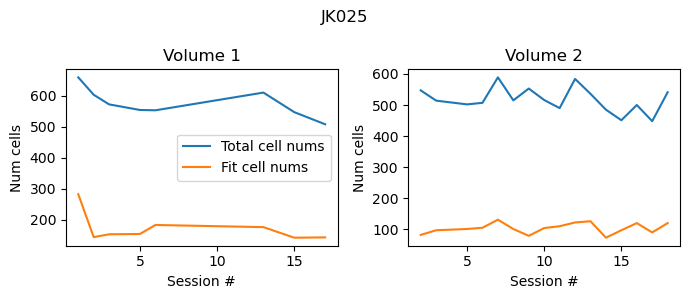

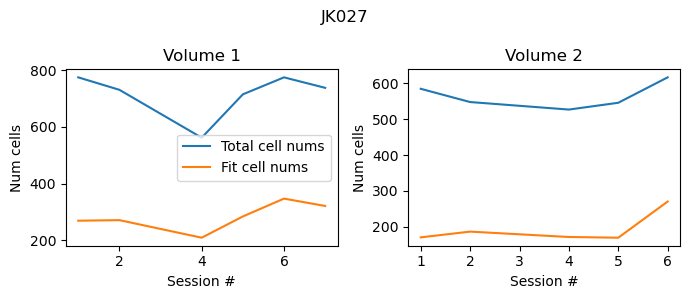

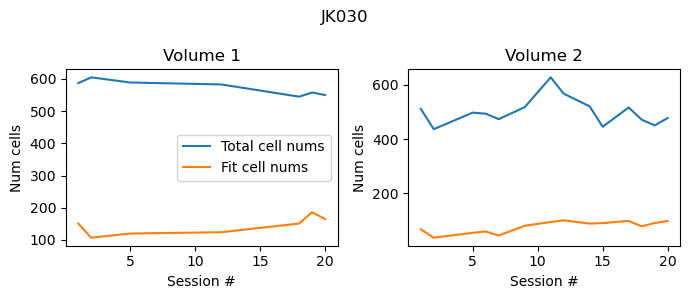

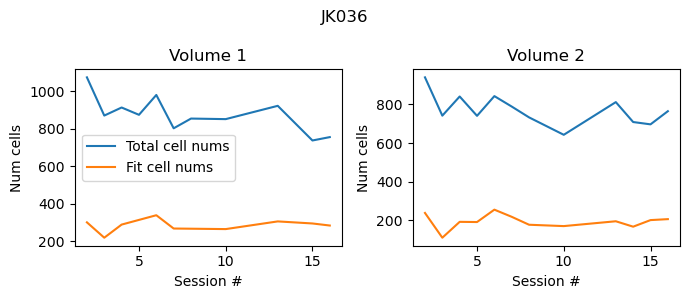

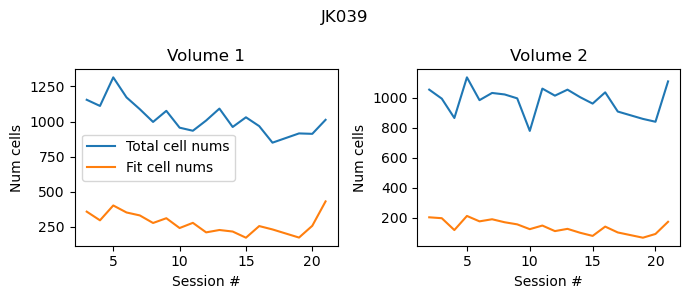

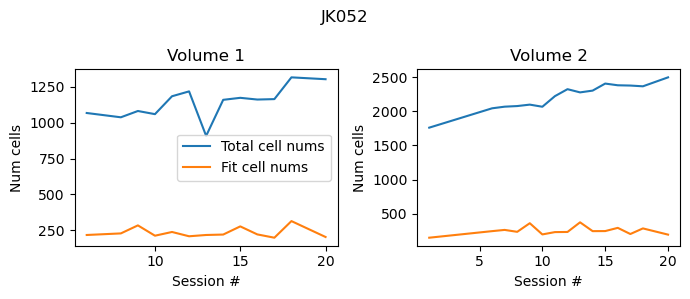

In [14]:
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for volume in range(1,3):
        sessions, total_cell_nums, fit_cell_nums = get_volume_cell_nums(mouse, volume, training_volume_df, pop_res_dir)
        ax[volume-1].plot(sessions, total_cell_nums, label='Total cell nums')
        ax[volume-1].plot(sessions, fit_cell_nums, label='Fit cell nums')
        ax[volume-1].set_xlabel('Session #')
        ax[volume-1].set_ylabel('Num cells')
        ax[volume-1].set_title(f'Volume {volume}')
    ax[0].legend()
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()

In [4]:
pop_res_dir = results_dir / 'pop_responses' / 'touch_before_answer'

num_fitcells_volume = np.zeros((len(mice), 2))
for mouse in mice:
    for volume in range(1,3):
        sessions, total_cell_nums, fit_cell_nums = get_volume_cell_nums(mouse, volume, training_volume_df, pop_res_dir)
        num_fitcells_volume[mice.index(mouse), volume-1] = np.mean(fit_cell_nums)

In [6]:
print(np.mean(num_fitcells_volume))
print(np.std(num_fitcells_volume))

196.51129793695586
67.95412393501688


# Number of touch neurons
- Roughly defined by those that have variance explained reduced by 0.05
    - From ridge for now. It takes a lot of time to run lasso
- Compare this with p-value-based touch neurons
    - Before answer, after answer, combined
    

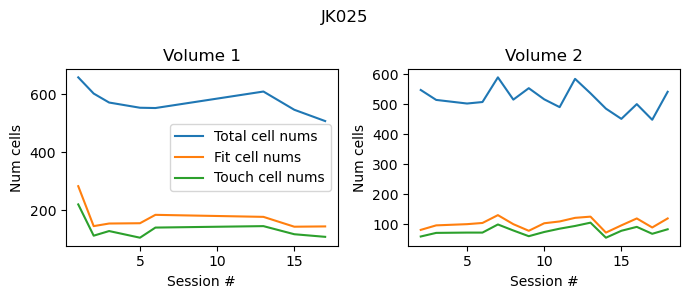

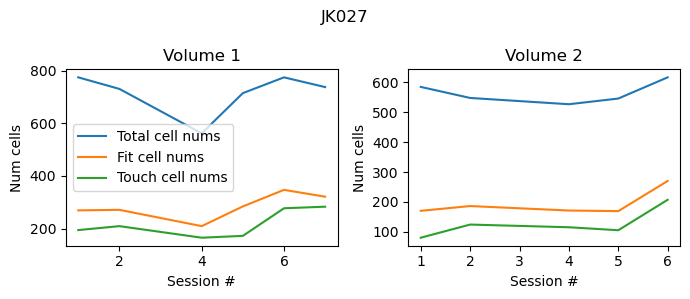

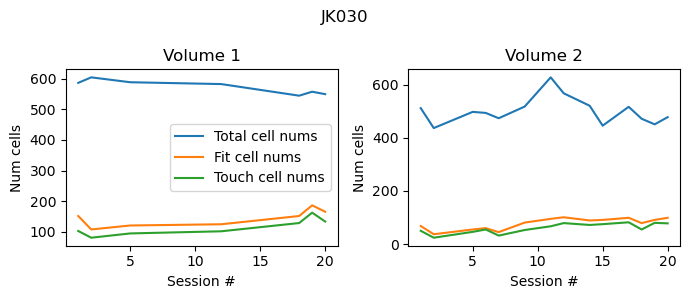

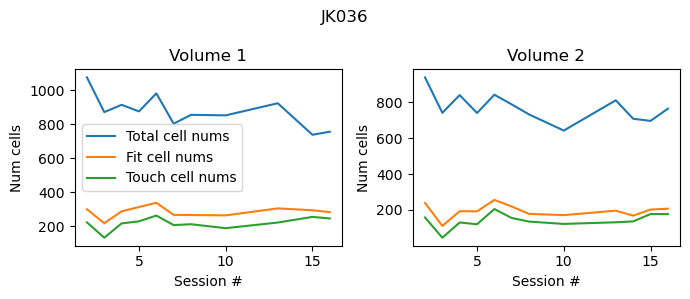

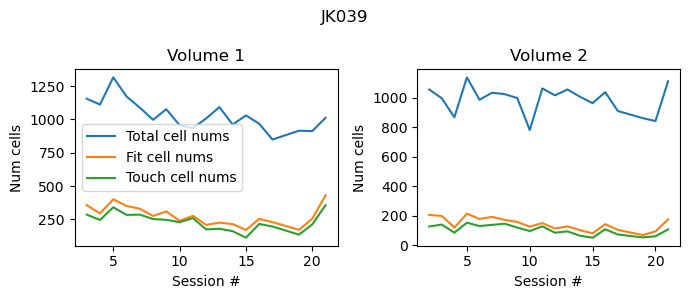

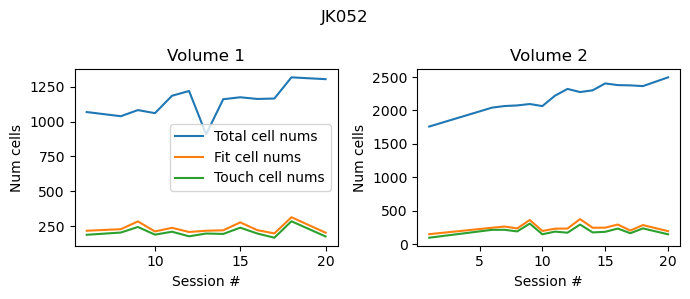

In [28]:
glm_dir = Path(r'C:\JK\results\neuron_glm\ridge\touch_combined')
touch_threshold = 0.05
fit_threshold = 0.05

num_cell_df = pd.DataFrame(columns=['mouse', 'volume', 'session', 'num_cells', 'num_fit_cells', 'num_touch_cells'])
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for axi in range(2):
        volume = axi + 1
        planes = range(1,5) if volume==1 else range(5,9)
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]

        num_touch_cell_sessions = []
        num_fit_cell_sessions = []
        num_cell_sessions = []
        for session in sessions:
            num_touch_cell = 0
            num_fit_cell = 0
            num_cell = 0
            for plane in planes:
                glm_fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
                with xr.open_dataset(glm_fn) as glm_result:
                    glm_result.load()
                    num_touch_cell += sum(glm_result.varexp_drop.sel(dropped_feature='touch') >= touch_threshold)
                    num_fit_cell += sum(glm_result.varexp_model_final >= fit_threshold)
                    num_cell += glm_result.cell_id.size

            num_touch_cell_sessions.append(num_touch_cell)
            num_fit_cell_sessions.append(num_fit_cell)
            num_cell_sessions.append(num_cell)
        num_cell_df = num_cell_df.append(pd.DataFrame({'mouse':mouse, 'volume':volume, 'session':sessions, 
                                                       'num_cells':num_cell_sessions, 'num_fit_cells':num_fit_cell_sessions, 'num_touch_cells':num_touch_cell_sessions}))
        ax[axi].plot(sessions, num_cell_sessions, label='Total cell nums')
        ax[axi].plot(sessions, num_fit_cell_sessions, label='Fit cell nums')
        ax[axi].plot(sessions, num_touch_cell_sessions, label='Touch cell nums')
        ax[axi].set_xlabel('Session #')
        ax[axi].set_ylabel('Num cells')
        ax[axi].set_title(f'Volume {volume}')
    ax[0].legend()
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()
        

In [29]:
num_cell_df.to_pickle(glm_dir / 'num_cells_stats.pkl')


In [33]:
print(num_cell_df.num_touch_cells.mean())
print(num_cell_df.num_touch_cells.std())

151.0
72.25024499680192


# From touch/tuning results
- From before answer, after answer, and all
- Touch response is calculated by changes from "baseline_frames", which is defined by activities before pole in.
    - It can be more like touch and/or whisking response. Before-pole whisking response cannot be guaranteed (although there seems stereotyped whisking before pole)

## Before answer

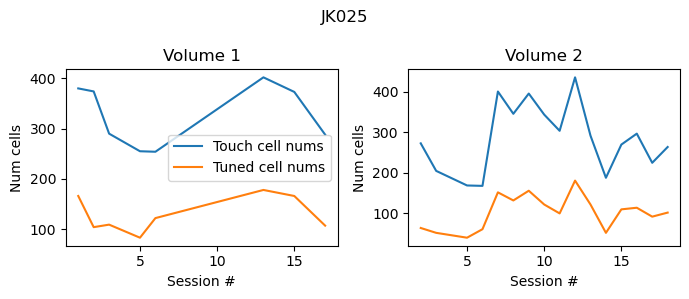

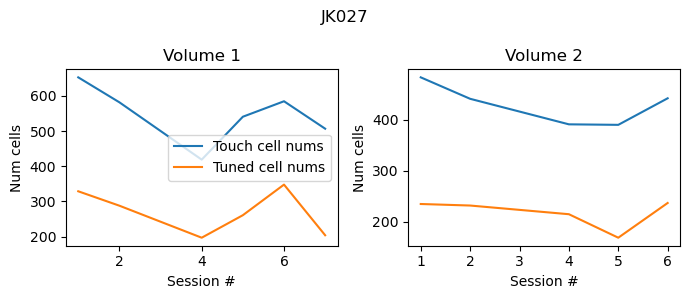

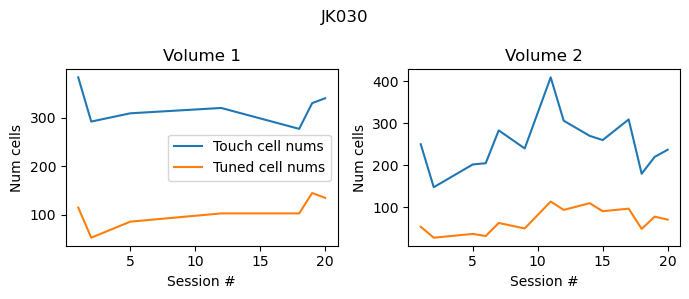

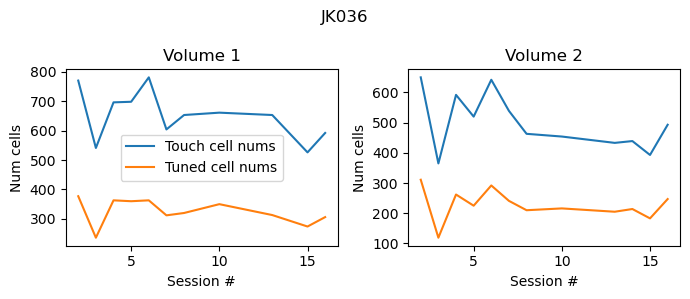

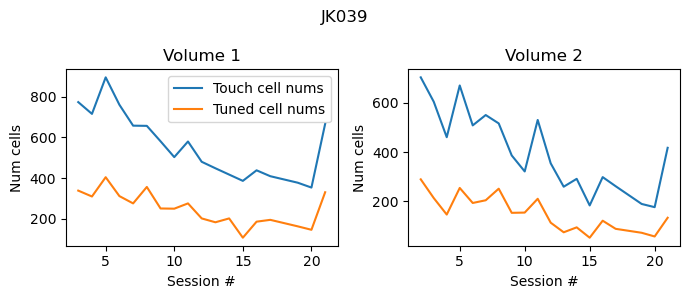

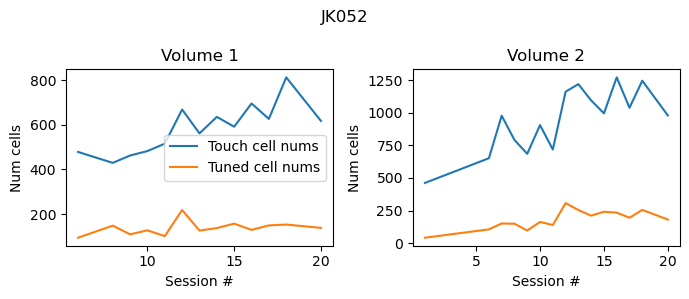

In [48]:
tt_dir = Path(r'C:\JK\results\touch_tuning')
num_touch_cell_all = []
num_tuned_cell_all = []
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for volume in range(1,3):
        planes = range(1,5) if volume==1 else range(5,9)
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]
        touch_window = 'before_answer'
        num_touch_cell_sessions = []
        num_tuned_cell_sessions = []
        for session in sessions:
            num_touch_cell_volume = 0
            num_tuned_cell_volume = 0
            for plane in planes:
                tt_fn = tt_dir / f'JK{mouse:03}S{session:02}_plane{plane}_touch_tuning_{touch_window}.npy'
                tt_result = np.load(tt_fn, allow_pickle=True).item()
                assert len(np.setdiff1d(tt_result['tuned_cell_inds'], tt_result['touch_cell_inds'])) == 0
                num_touch_cells = len(tt_result['touch_cell_inds'])
                num_tuned_cells = len(tt_result['tuned_cell_inds'])
                num_touch_cell_volume += num_touch_cells
                num_tuned_cell_volume += num_tuned_cells
            num_touch_cell_sessions.append(num_touch_cell_volume)
            num_tuned_cell_sessions.append(num_tuned_cell_volume)
        num_touch_cell_all.append(num_touch_cell_sessions)
        num_tuned_cell_all.append(num_tuned_cell_sessions)
        axi = volume-1
        ax[axi].plot(sessions, num_touch_cell_sessions, label='Touch cell nums')
        ax[axi].plot(sessions, num_tuned_cell_sessions, label='Tuned cell nums')
        ax[axi].set_xlabel('Session #')
        ax[axi].set_ylabel('Num cells')
        ax[axi].set_title(f'Volume {volume}')
    ax[0].legend()
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()

In [51]:
print(np.mean(np.array([np.mean(n) for n in num_touch_cell_all])))
print(np.std(np.array([np.mean(n) for n in num_touch_cell_all])))

483.98007617382615
186.1162429974963


In [52]:
print(np.mean(np.array([np.mean(n) for n in num_tuned_cell_all])))
print(np.std(np.array([np.mean(n) for n in num_tuned_cell_all])))

180.57481491461758
74.52151970646258


touch cells after_answer
451.5087864864181
161.87596384749557
tuned cells after_answer
140.54873654001943
63.4318513839356


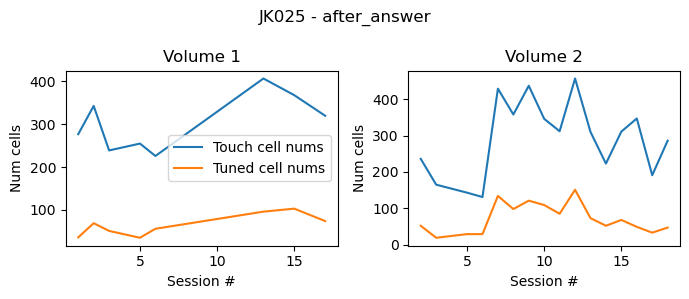

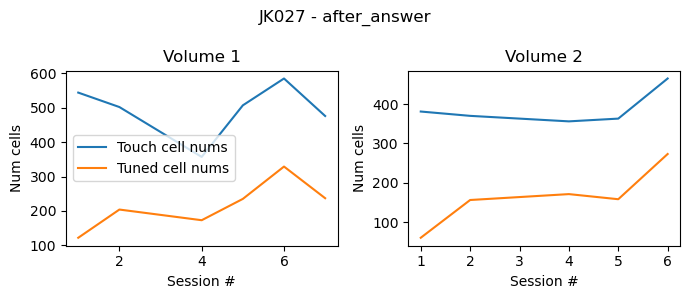

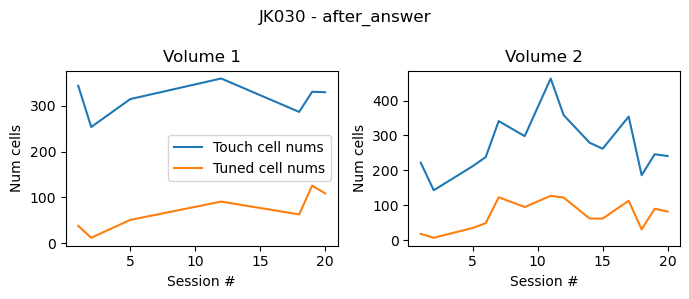

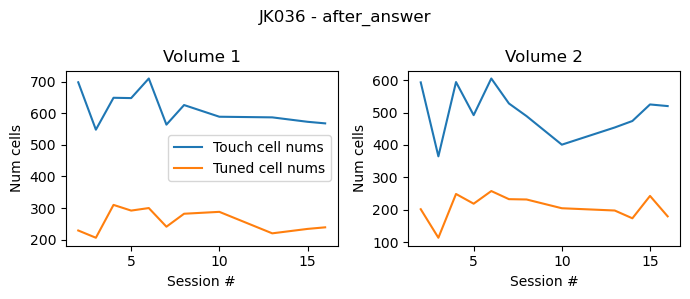

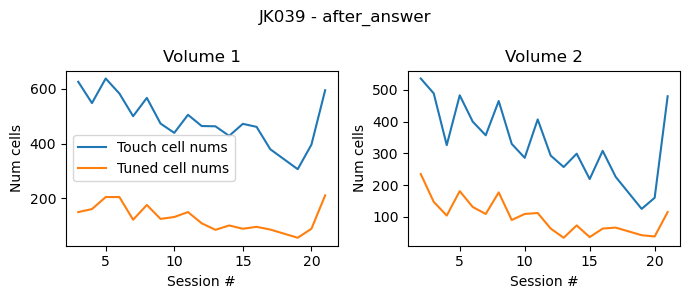

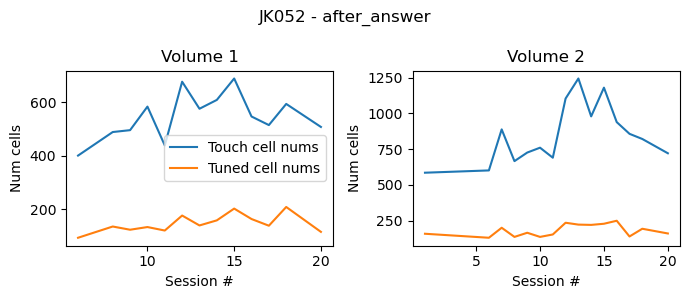

In [53]:
tt_dir = Path(r'C:\JK\results\touch_tuning')
touch_window = 'after_answer'
num_touch_cell_all = []
num_tuned_cell_all = []
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for volume in range(1,3):
        planes = range(1,5) if volume==1 else range(5,9)
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]
        
        num_touch_cell_sessions = []
        num_tuned_cell_sessions = []
        for session in sessions:
            num_touch_cell_volume = 0
            num_tuned_cell_volume = 0
            for plane in planes:
                tt_fn = tt_dir / f'JK{mouse:03}S{session:02}_plane{plane}_touch_tuning_{touch_window}.npy'
                tt_result = np.load(tt_fn, allow_pickle=True).item()
                assert len(np.setdiff1d(tt_result['tuned_cell_inds'], tt_result['touch_cell_inds'])) == 0
                num_touch_cells = len(tt_result['touch_cell_inds'])
                num_tuned_cells = len(tt_result['tuned_cell_inds'])
                num_touch_cell_volume += num_touch_cells
                num_tuned_cell_volume += num_tuned_cells
            num_touch_cell_sessions.append(num_touch_cell_volume)
            num_tuned_cell_sessions.append(num_tuned_cell_volume)
        num_touch_cell_all.append(num_touch_cell_sessions)
        num_tuned_cell_all.append(num_tuned_cell_sessions)
        axi = volume-1
        ax[axi].plot(sessions, num_touch_cell_sessions, label='Touch cell nums')
        ax[axi].plot(sessions, num_tuned_cell_sessions, label='Tuned cell nums')
        ax[axi].set_xlabel('Session #')
        ax[axi].set_ylabel('Num cells')
        ax[axi].set_title(f'Volume {volume}')
    ax[0].legend()
    fig.suptitle(f'JK{mouse:03} - {touch_window}')
    fig.tight_layout()

print(f'touch cells {touch_window}')
print(np.mean(np.array([np.mean(n) for n in num_touch_cell_all])))
print(np.std(np.array([np.mean(n) for n in num_touch_cell_all])))
print(f'tuned cells {touch_window}')
print(np.mean(np.array([np.mean(n) for n in num_tuned_cell_all])))
print(np.std(np.array([np.mean(n) for n in num_tuned_cell_all])))

touch cells all
542.4589070103872
206.1416164404337
tuned cells all
254.42966879003063
95.2517096457667


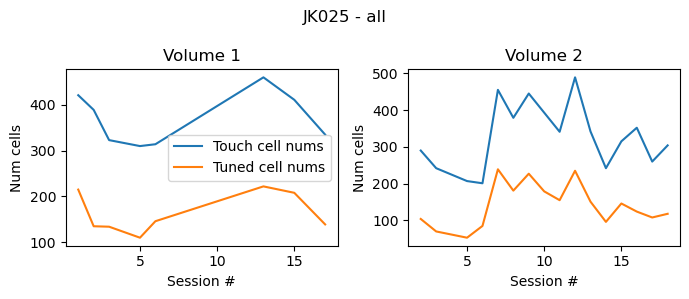

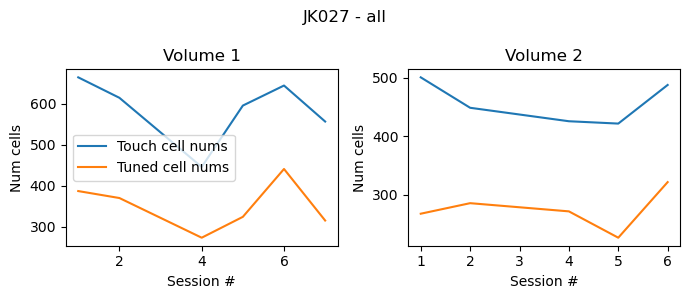

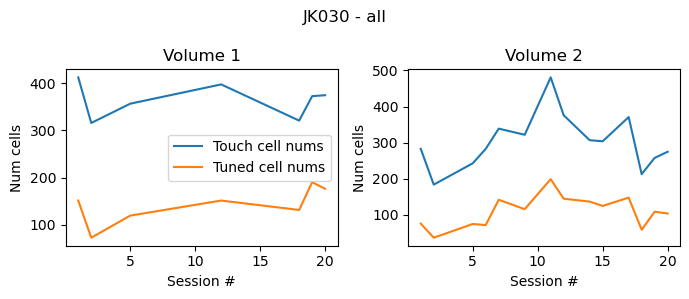

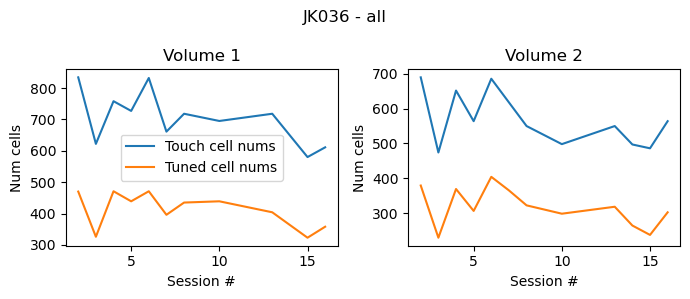

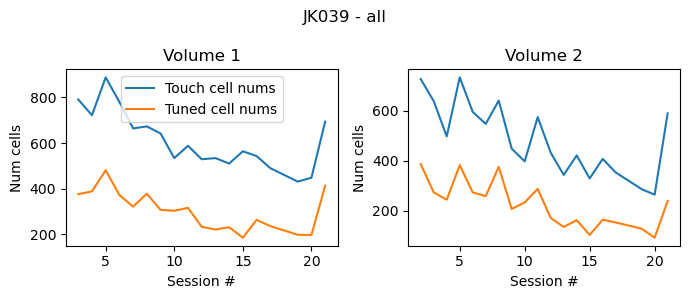

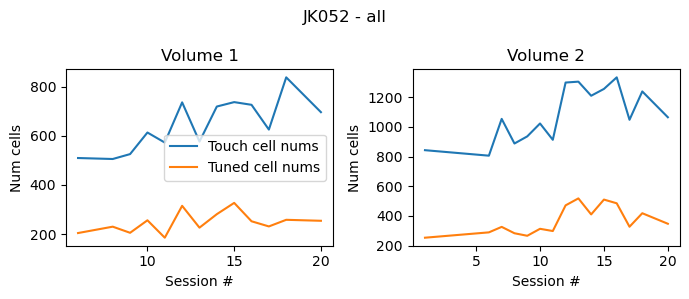

In [54]:
tt_dir = Path(r'C:\JK\results\touch_tuning')
touch_window = 'all'
num_touch_cell_all = []
num_tuned_cell_all = []
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for volume in range(1,3):
        planes = range(1,5) if volume==1 else range(5,9)
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]
        
        num_touch_cell_sessions = []
        num_tuned_cell_sessions = []
        for session in sessions:
            num_touch_cell_volume = 0
            num_tuned_cell_volume = 0
            for plane in planes:
                tt_fn = tt_dir / f'JK{mouse:03}S{session:02}_plane{plane}_touch_tuning_{touch_window}.npy'
                tt_result = np.load(tt_fn, allow_pickle=True).item()
                assert len(np.setdiff1d(tt_result['tuned_cell_inds'], tt_result['touch_cell_inds'])) == 0
                num_touch_cells = len(tt_result['touch_cell_inds'])
                num_tuned_cells = len(tt_result['tuned_cell_inds'])
                num_touch_cell_volume += num_touch_cells
                num_tuned_cell_volume += num_tuned_cells
            num_touch_cell_sessions.append(num_touch_cell_volume)
            num_tuned_cell_sessions.append(num_tuned_cell_volume)
        num_touch_cell_all.append(num_touch_cell_sessions)
        num_tuned_cell_all.append(num_tuned_cell_sessions)
        axi = volume-1
        ax[axi].plot(sessions, num_touch_cell_sessions, label='Touch cell nums')
        ax[axi].plot(sessions, num_tuned_cell_sessions, label='Tuned cell nums')
        ax[axi].set_xlabel('Session #')
        ax[axi].set_ylabel('Num cells')
        ax[axi].set_title(f'Volume {volume}')
    ax[0].legend()
    fig.suptitle(f'JK{mouse:03} - {touch_window}')
    fig.tight_layout()

print(f'touch cells {touch_window}')
print(np.mean(np.array([np.mean(n) for n in num_touch_cell_all])))
print(np.std(np.array([np.mean(n) for n in num_touch_cell_all])))
print(f'tuned cells {touch_window}')
print(np.mean(np.array([np.mean(n) for n in num_tuned_cell_all])))
print(np.std(np.array([np.mean(n) for n in num_tuned_cell_all])))

## GLM vs t-test touch cells and tuned cells
- Are t-test touch cells included in GLM fit cells?
- Are GLM touch cells included in t-test touch cells?
    - What's the proportion?
    - What's the distribution of responses?
- Are t-test tuned cells included in GLM touch cells?


In [2]:
glm_dir = Path(r'C:\JK\results\neuron_glm\ridge\touch_combined')
touch_threshold = 0.05
fit_threshold = 0.05
tt_dir = Path(r'C:\JK\results\touch_tuning')
touch_windows = ['before_answer', 'after_answer', 'all']

mouse = 25
volume = 1
planes = range(1,5) if volume==1 else range(5,9)
sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]

session = sessions[0]
ind_cell_df = pd.DataFrame(columns=['mouse', 'volume', 'session', 'plane',
                                    'ind_fit_glm', 'ind_touch_glm',
                                    'ind_touch_ttest_all', 'ind_tuned_ttest_all',
                                    'ind_touch_ttest_before_answer',
                                    'ind_tuned_ttest_before_answer',
                                    'ind_touch_ttest_after_answer',
                                    'ind_tuned_ttest_after_answer',
                                    ])
plane = planes[0]
glm_fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
with xr.open_dataset(glm_fn) as glm_result:
    glm_result.load()


In [31]:
touch_window = touch_windows[2]
tt_fn = tt_dir / f'JK{mouse:03}S{session:02}_plane{plane}_touch_tuning_{touch_window}.npy'
tt_result = np.load(tt_fn, allow_pickle=True).item()

In [33]:
ttest_touch_cell_inds = tt_result['touch_cell_inds'] # cell index, not index of cell_inds
ttest_tuned_cell_inds = tt_result['tuned_cell_inds']
glm_fit_cell_inds = glm_result.cell_id[np.where(glm_result.varexp_model_final >= fit_threshold)[0]].values
glm_touch_cell_inds = glm_result.cell_id[np.where(glm_result.varexp_drop.sel(dropped_feature='touch') >= touch_threshold)[0]].values


In [34]:
print(np.intersect1d(glm_fit_cell_inds, ttest_touch_cell_inds).size / np.union1d(glm_fit_cell_inds, ttest_touch_cell_inds).size)
print(np.intersect1d(glm_fit_cell_inds, ttest_touch_cell_inds).size / len(ttest_touch_cell_inds))
print(np.intersect1d(glm_fit_cell_inds, ttest_touch_cell_inds).size / len(glm_fit_cell_inds))

0.5714285714285714
0.5714285714285714
1.0


In [35]:
print(np.intersect1d(glm_fit_cell_inds, ttest_tuned_cell_inds).size / np.union1d(glm_fit_cell_inds, ttest_tuned_cell_inds).size)
print(np.intersect1d(glm_fit_cell_inds, ttest_tuned_cell_inds).size / len(ttest_tuned_cell_inds))
print(np.intersect1d(glm_fit_cell_inds, ttest_tuned_cell_inds).size / len(glm_fit_cell_inds))

0.46551724137931033
0.6585365853658537
0.6136363636363636


In [36]:
print(np.intersect1d(glm_touch_cell_inds, ttest_touch_cell_inds).size / np.union1d(glm_touch_cell_inds, ttest_touch_cell_inds).size)
print(np.intersect1d(glm_touch_cell_inds, ttest_touch_cell_inds).size / len(ttest_touch_cell_inds))
print(np.intersect1d(glm_touch_cell_inds, ttest_touch_cell_inds).size / len(glm_touch_cell_inds))

0.45454545454545453
0.45454545454545453
1.0


In [37]:
print(np.intersect1d(glm_touch_cell_inds, ttest_tuned_cell_inds).size / np.union1d(glm_touch_cell_inds, ttest_tuned_cell_inds).size)
print(np.intersect1d(glm_touch_cell_inds, ttest_tuned_cell_inds).size / len(ttest_tuned_cell_inds))
print(np.intersect1d(glm_touch_cell_inds, ttest_tuned_cell_inds).size / len(glm_touch_cell_inds))

0.35714285714285715
0.4878048780487805
0.5714285714285714


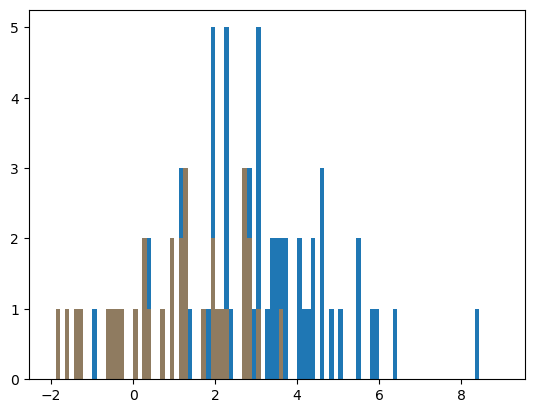

In [38]:
fig, ax = plt.subplots()
# tt_touch_not_glm_touch_cell_inds = np.setdiff1d(ttest_touch_cell_inds, glm_touch_cell_inds)
tt_touch_not_glm_touch_cell_inds = np.setdiff1d(ttest_touch_cell_inds, glm_fit_cell_inds)
ax.hist(tt_result['touch_response'].sel(cell_index=tt_result['touch_cell_inds']).mean(axis=0),
         bins=np.linspace(-2,9,100));
ax.hist(tt_result['touch_response'].sel(cell_index=tt_touch_not_glm_touch_cell_inds).mean(axis=0),
         bins=np.linspace(-2,9,100),
         alpha=0.5);


## Think about touch / tuned cell definition later
- Can calculate the other things again easily.
- One thing for sure is that t-test definition can be very loose.
    - E.g., can be from whisking cells
- GLM fitting - should I only care about when touch happend?

## Gather data from all volumes
- It makes more sense to compare with t-test from all touches
- infos:
    - glm touch / glm fit
    - IOU (glm touch, ttest touch)
    - intersect(glm touch, ttest touch) / ttest touch
    - intersect(glm touch, ttest touch) / glm touch
    - IOU (glm fit, ttest touch)
    - intersect(glm fit, ttest touch) / ttest touch
    - intersect(glm fit, ttest touch) / glm fit
    

In [48]:
ind_cell_df = pd.DataFrame(columns=['mouse', 'volume', 'session',
                                    'ind_fit_glm', 'ind_touch_glm',
                                    'ind_touch_ttest_all', 'ind_tuned_ttest_all',
                                    'ind_touch_ttest_before_answer',
                                    'ind_tuned_ttest_before_answer',
                                    'ind_touch_ttest_after_answer',
                                    'ind_tuned_ttest_after_answer',
                                    ])
glm_dir = Path(r'C:\JK\results\neuron_glm\ridge\touch_combined')
touch_threshold = 0.05
fit_threshold = 0.05
tt_dir = Path(r'C:\JK\results\touch_tuning')
touch_windows = ['before_answer', 'after_answer', 'all']

for mouse in mice:
    for volume in range(1,3):
        planes = range(1,5) if volume==1 else range(5,9)
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]

        for session in sessions:
            tt_touch_inds = [[],[],[]]
            tt_tuned_inds = [[],[],[]]
            glm_fit_inds = []
            glm_touch_inds = []
            for plane in planes:

                glm_fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
                with xr.open_dataset(glm_fn) as glm_result:
                    glm_result.load()
                assert glm_result.cell_id.max() < 1000
                glm_fit_cell_inds = plane*1000 + glm_result.cell_id[np.where(glm_result.varexp_model_final >= fit_threshold)[0]].values
                glm_touch_cell_inds = plane*1000 + glm_result.cell_id[np.where(glm_result.varexp_drop.sel(dropped_feature='touch') >= touch_threshold)[0]].values
                glm_fit_inds.extend(glm_fit_cell_inds)
                glm_touch_inds.extend(glm_touch_cell_inds)
                for twi, touch_window in enumerate(touch_windows):
                    tt_fn = tt_dir / f'JK{mouse:03}S{session:02}_plane{plane}_touch_tuning_{touch_window}.npy'
                    tt_result = np.load(tt_fn, allow_pickle=True).item()
                    assert tt_result['touch_response'].cell_index.max() < 1000
                    ttest_touch_cell_inds = plane*1000 + tt_result['touch_cell_inds'] # cell index, not index of cell_inds
                    ttest_tuned_cell_inds = plane*1000 + tt_result['tuned_cell_inds']
                    tt_touch_inds[twi].extend(ttest_touch_cell_inds)
                    tt_tuned_inds[twi].extend(ttest_tuned_cell_inds)
            temp_df = pd.DataFrame({'mouse':mouse, 'volume':volume, 'session':session,
                                    'ind_fit_glm': [np.array(glm_fit_inds)],
                                    'ind_touch_glm': [np.array(glm_touch_inds)],
                                    'ind_touch_ttest_all': [np.array(tt_touch_inds[2])],
                                    'ind_tuned_ttest_all': [np.array(tt_tuned_inds[2])],
                                    'ind_touch_ttest_before_answer': [np.array(tt_touch_inds[0])],
                                    'ind_tuned_ttest_before_answer': [np.array(tt_tuned_inds[0])],
                                    'ind_touch_ttest_after_answer': [np.array(tt_touch_inds[1])],
                                    'ind_tuned_ttest_after_answer': [np.array(tt_tuned_inds[1])],
                                    })
            ind_cell_df = ind_cell_df.append(temp_df)


In [49]:
save_dir = Path(r'C:\JK\results\touch_tuning')
save_fn = save_dir / 'glm_vs_ttest_ind_cell_df.pkl'
ind_cell_df.to_pickle(save_fn)

In [57]:
ind_cell_df.columns

Index(['mouse', 'volume', 'session', 'ind_fit_glm', 'ind_touch_glm',
       'ind_touch_ttest_all', 'ind_tuned_ttest_all',
       'ind_touch_ttest_before_answer', 'ind_tuned_ttest_before_answer',
       'ind_touch_ttest_after_answer', 'ind_tuned_ttest_after_answer',
       'glm_touch_over_fit'],
      dtype='object')

In [62]:
ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_glm'], row['ind_touch_ttest_before_answer'])) , axis=1)
ind_cell_df.apply(lambda row: len(np.union1d(row['ind_touch_glm'], row['ind_touch_ttest_before_answer'])), axis=1)

0     393
0     378
0     305
0     273
0     269
     ... 
0    1018
0    1281
0    1052
0    1254
0     999
Length: 144, dtype: int64

In [75]:
ind_cell_df['glm_touch_over_fit'] = ind_cell_df.apply(lambda row: len(row['ind_touch_glm']) / len(row['ind_fit_glm']), axis=1)
ind_cell_df['iou_glm_touch_tt_touch_before'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_glm'], row['ind_touch_ttest_before_answer'])) / \
                                                                 len(np.union1d(row['ind_touch_glm'], row['ind_touch_ttest_before_answer'])), axis=1)
ind_cell_df['iou_glm_touch_tt_touch_after'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_glm'], row['ind_touch_ttest_after_answer'])) / \
                                                                len(np.union1d(row['ind_touch_glm'], row['ind_touch_ttest_after_answer'])), axis=1)
ind_cell_df['iou_glm_touch_tt_touch_all'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_glm'], row['ind_touch_ttest_all'])) / \
                                                              len(np.union1d(row['ind_touch_glm'], row['ind_touch_ttest_all'])), axis=1)
ind_cell_df['glm_touch_over_tt_touch_before'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_glm'], row['ind_touch_ttest_before_answer'])) / \
                                                                  len(row['ind_touch_ttest_before_answer']), axis=1)
ind_cell_df['glm_touch_over_tt_touch_after'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_glm'], row['ind_touch_ttest_after_answer'])) / \
                                                                 len(row['ind_touch_ttest_after_answer']), axis=1)
ind_cell_df['glm_touch_over_tt_touch_all'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_glm'], row['ind_touch_ttest_all'])) / \
                                                               len(row['ind_touch_ttest_all']), axis=1)
ind_cell_df['tt_touch_before_over_glm_touch'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_glm'], row['ind_touch_ttest_before_answer'])) / \
                                                                  len(row['ind_touch_glm']), axis=1)
ind_cell_df['tt_touch_after_over_glm_touch'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_glm'], row['ind_touch_ttest_after_answer'])) / \
                                                                 len(row['ind_touch_glm']), axis=1)
ind_cell_df['tt_touch_all_over_glm_touch'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_glm'], row['ind_touch_ttest_all'])) / \
                                                                len(row['ind_touch_glm']), axis=1)
ind_cell_df['iou_tt_touch_all_tt_touch_before'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_ttest_all'], row['ind_touch_ttest_before_answer'])) / \
                                                                 len(np.union1d(row['ind_touch_ttest_all'], row['ind_touch_ttest_before_answer'])), axis=1)
ind_cell_df['iou_tt_touch_all_tt_touch_after'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_ttest_all'], row['ind_touch_ttest_after_answer'])) / \
                                                                 len(np.union1d(row['ind_touch_ttest_all'], row['ind_touch_ttest_after_answer'])), axis=1)    
ind_cell_df['iou_tt_touch_before_tt_touch_after'] = ind_cell_df.apply(lambda row: len(np.intersect1d(row['ind_touch_ttest_before_answer'], row['ind_touch_ttest_after_answer'])) / \
                                                                 len(np.union1d(row['ind_touch_ttest_before_answer'], row['ind_touch_ttest_after_answer'])), axis=1)    






In [67]:
print(ind_cell_df.glm_touch_over_fit.mean())
print(ind_cell_df.glm_touch_over_fit.std())

0.7716010734846434
0.08743623472447566


In [68]:
print(ind_cell_df.iou_glm_touch_tt_touch_all.mean())
print(ind_cell_df.iou_glm_touch_tt_touch_all.std())

0.2492694456549972
0.08170414881357364


In [69]:
print(ind_cell_df.glm_touch_over_tt_touch_all.mean())
print(ind_cell_df.glm_touch_over_tt_touch_all.std())

0.2549064477565584
0.08450492773743866


In [70]:
print(ind_cell_df.tt_touch_all_over_glm_touch.mean())
print(ind_cell_df.tt_touch_all_over_glm_touch.std())

0.9247639081807281
0.0626055998031698


In [72]:
print(ind_cell_df.iou_glm_touch_tt_touch_before.mean())
print(ind_cell_df.iou_glm_touch_tt_touch_before.std())

0.27615119320134496
0.08479488803997437


In [73]:
print(ind_cell_df.glm_touch_over_tt_touch_before.mean())
print(ind_cell_df.glm_touch_over_tt_touch_before.std())

0.28512204499741994
0.0893806506491783


In [74]:
print(ind_cell_df.tt_touch_all_over_glm_touch.mean())
print(ind_cell_df.tt_touch_all_over_glm_touch.std())

0.9247639081807281
0.0626055998031698


In [76]:
print(ind_cell_df.iou_tt_touch_all_tt_touch_before.mean())
print(ind_cell_df.iou_tt_touch_all_tt_touch_before.std())

0.7196851725667344
0.09295304063217104


In [77]:
print(ind_cell_df.iou_tt_touch_all_tt_touch_after.mean())
print(ind_cell_df.iou_tt_touch_all_tt_touch_after.std())

0.6165564088184706
0.10611477116026193


In [78]:
print(ind_cell_df.iou_tt_touch_before_tt_touch_after.mean())
print(ind_cell_df.iou_tt_touch_before_tt_touch_after.std())

0.5347450496024877
0.11731521377969921


# Variance explained of fit cells

In [3]:
lda_dir = results_dir / 'neural_stretching/lda_performances'
pca_expvar_fn = lda_dir / 'explained_variances_expert_all_sessions_before_answer.pkl'
pca_expvar_before_answer = pd.read_pickle(pca_expvar_fn)
# this is not normalized response, but just response from normalized spikes

In [7]:
pop_res_dir = results_dir / 'pop_responses/touch_before_answer'
mouse = 25
volume = 1
session = 1
pop_res_fn = pop_res_dir / f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
pop_res = np.load(pop_res_fn, allow_pickle=True).item()

In [17]:
num_dim = 7
response_xr = pop_res['per_touch_response_xr_fit']
# response normalization per fit cell
response_xr = (response_xr - response_xr.mean(axis=0)) / response_xr.std(axis=0)
pca = PCA()
pca.fit(response_xr)
np.cumsum(pca.explained_variance_ratio_)[num_dim-1]

0.5018522

In [34]:
pop_res_dir = results_dir / 'pop_responses/touch_before_answer'
num_dim = 7
pca_expvar_df = pd.DataFrame(columns=['mouse', 'volume', 'session', 'exp_var'])
for mouse in mice:
    for volume in range(1,3):
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]
        for session in sessions:
            pop_res_fn = pop_res_dir / f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
            pop_res = np.load(pop_res_fn, allow_pickle=True).item()
            response_xr = pop_res['per_touch_response_xr_fit']
            # response normalization per fit cell
            response_xr = (response_xr - response_xr.mean(axis=0)) / response_xr.std(axis=0)
            pca = PCA()
            pca.fit(response_xr)
            exp_var = np.cumsum(pca.explained_variance_ratio_)[num_dim-1]
            temp_df = pd.DataFrame({'mouse': mouse, 'volume': volume, 'session': session,
                                    'exp_var': exp_var}, index=[0])
            pca_expvar_df = pca_expvar_df.append(temp_df)


In [39]:
pca_dir = results_dir / 'neural_stretching/pca'
save_fn = pca_dir / 'expvar_0.05_ptf_1_touch_before_answer.pkl'
pca_expvar_df.to_pickle(save_fn)

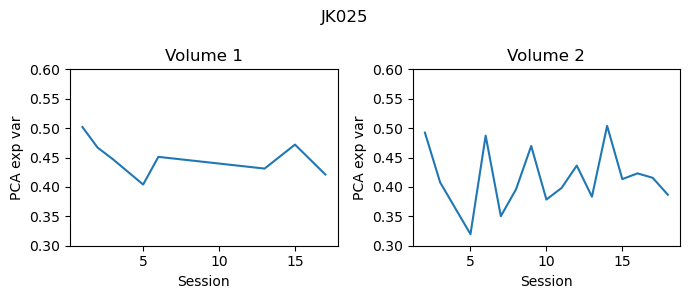

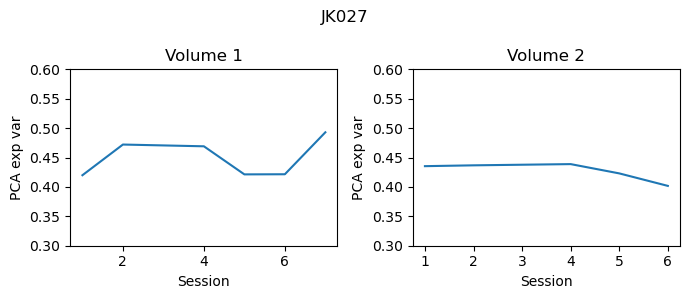

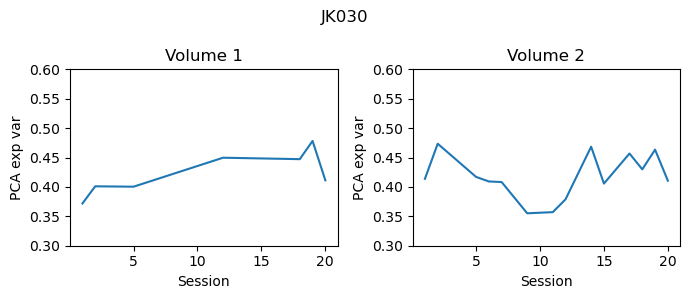

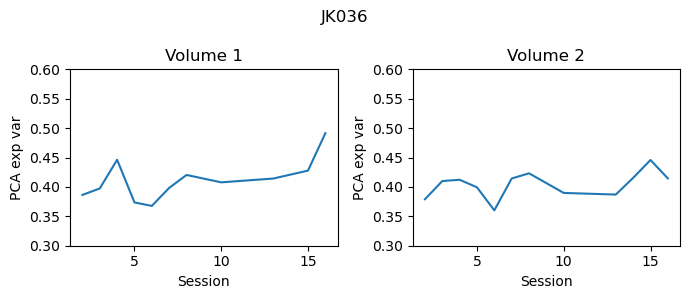

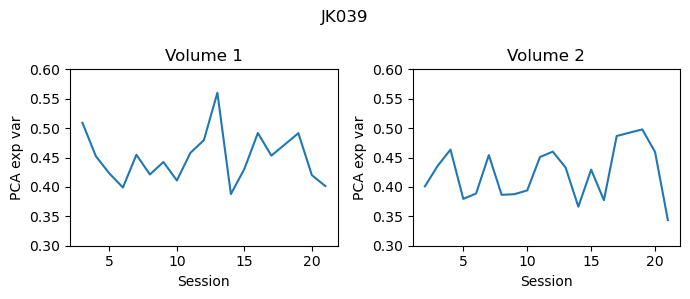

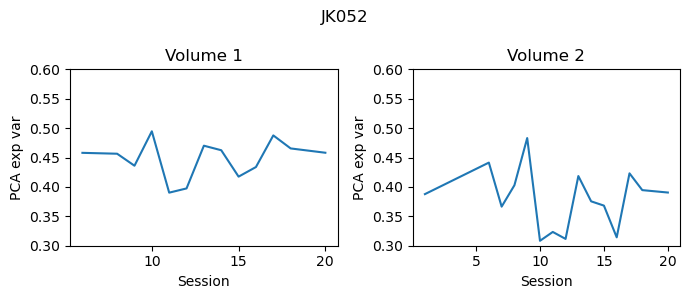

In [37]:
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for volume in range(1,3):
        axi = volume - 1
        temp_df = pca_expvar_df.query('mouse==@mouse and volume==@volume')
        ax[axi].plot(temp_df.session.values, temp_df.exp_var.values)
        ax[axi].set_xlabel('Session')
        ax[axi].set_ylabel('PCA exp var')
        ax[axi].set_title(f'Volume {volume}')
        ax[axi].set_ylim(0.3, 0.6)
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()

# Save clustering index results


In [ ]:
# It took 40 s to run all training volumes
pop_res_dir = results_dir / 'pop_responses/touch_before_answer'
varexp_threshold = 0.05
post_touch_frames = 1
num_dims = 7

clustering_index_df = pd.DataFrame(columns=['mouse', 'volume', 'session',
                                            'clustering_index', 'num_dim'])
for mi, mouse in enumerate(mice):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    for vi, volume in enumerate([1,2]):
        temp_df = training_volume_df.query('mouse==@mouse and volume==@volume')
        sessions = [int(s) for s in temp_df.session.values]
        for session in sessions:
            touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
            touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
            response_xr = touch_response_results['per_touch_response_xr_fit']
            response_df = touch_response_results['per_touch_response_df']

            clustering_index = ci.calculate_clustering_index(response_xr, response_df,
                                                                num_dims=num_dims)
            # default: balancing trial numbers, using 30 trials in each angle
            temp_df = pd.DataFrame({'mouse': mouse, 'volume': volume, 'session': session,
                                    'clustering_index': clustering_index, 'num_dim': num_dims})
            clustering_index_df = clustering_index_df.append(temp_df)

save_dir = Path(r'C:\JK\results\neural_stretching\clustering_index')
save_fn = save_dir / 'clustering_index_training_before_touch_0.05_ptf_1.pkl'
clustering_index_df.to_pickle(save_fn)

# Num touch cell (GLM) vs Clustering index

In [5]:
clustering_index_dir = Path(r'C:\JK\results\neural_stretching\clustering_index')
clustering_index_fn = clustering_index_dir / 'clustering_index_training_before_touch_0.05_ptf_1.pkl'
clustering_index_df = pd.read_pickle(clustering_index_fn)

touch_dir = Path(r'C:\JK\results\touch_tuning')
touch_cell_fn = touch_dir / 'glm_vs_ttest_ind_cell_df.pkl'
ind_cell_df = pd.read_pickle(touch_cell_fn)

In [7]:
ind_cell_df.columns

Index(['mouse', 'volume', 'session', 'ind_fit_glm', 'ind_touch_glm',
       'ind_touch_ttest_all', 'ind_tuned_ttest_all',
       'ind_touch_ttest_before_answer', 'ind_tuned_ttest_before_answer',
       'ind_touch_ttest_after_answer', 'ind_tuned_ttest_after_answer'],
      dtype='object')

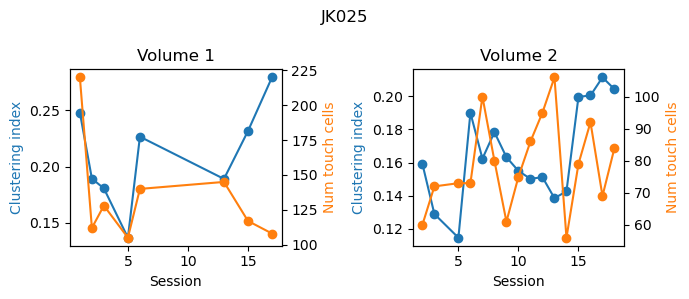

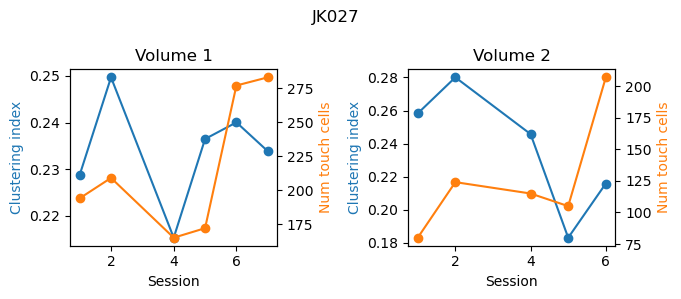

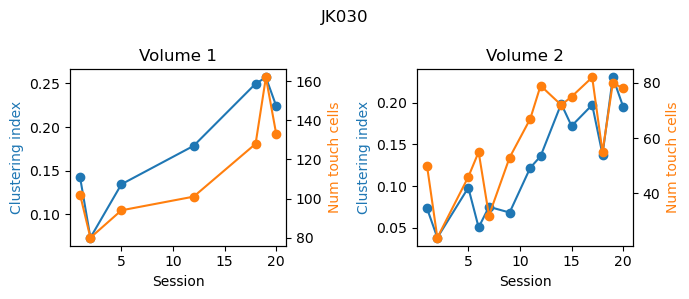

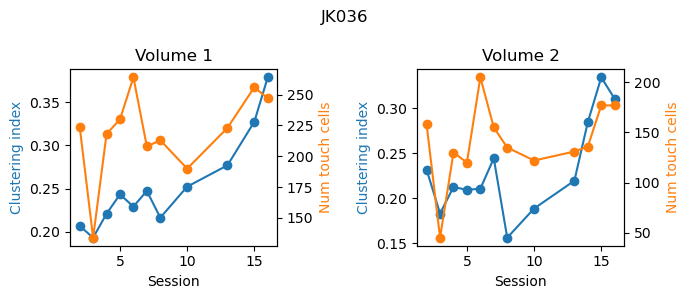

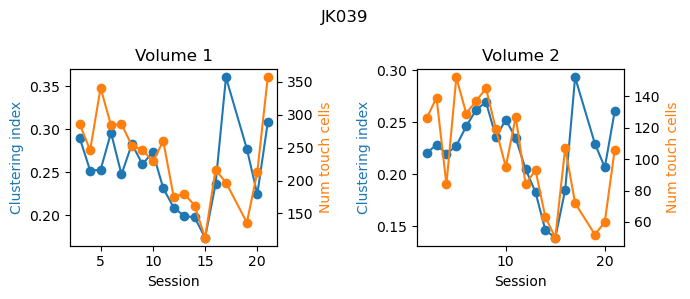

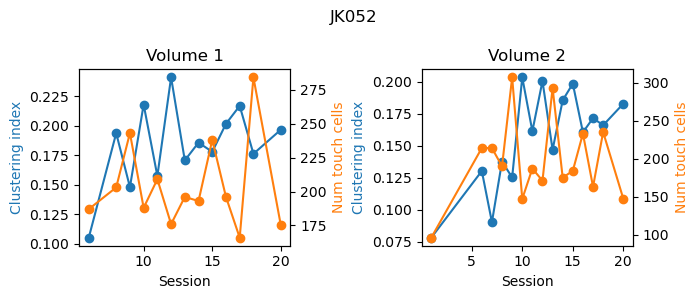

In [10]:
ind_cell_df['num_touch_glm'] = ind_cell_df.apply(lambda x: len(x['ind_touch_glm']), axis=1)
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for volume in range(1,3):
        axi = volume - 1
        temp_df = clustering_index_df.query('mouse==@mouse and volume==@volume')
        ax[axi].plot(temp_df.session.values, temp_df.clustering_index.values, 
                     '-o', color='C0')
        ax[axi].set_xlabel('Session')
        ax[axi].set_ylabel('Clustering index', color='C0')
        ax[axi].set_title(f'Volume {volume}')
        axx = ax[axi].twinx()
        temp_df = ind_cell_df.query('mouse==@mouse and volume==@volume')
        axx.plot(temp_df.session.values, temp_df.num_touch_glm.values, 
                 '-o', color='C1')
        axx.set_ylabel('Num touch cells', color='C1')
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()
        

# num tuned cells vs CI
- Tuned cells defined by tuned by t-test among GLM touch cells

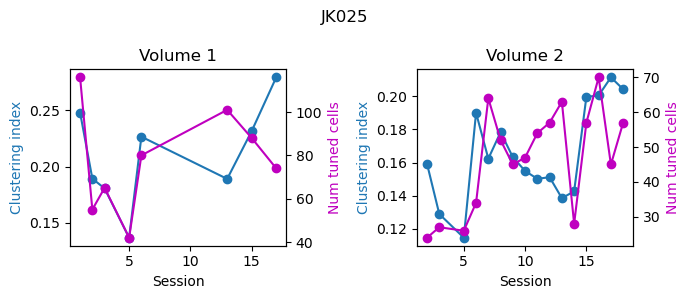

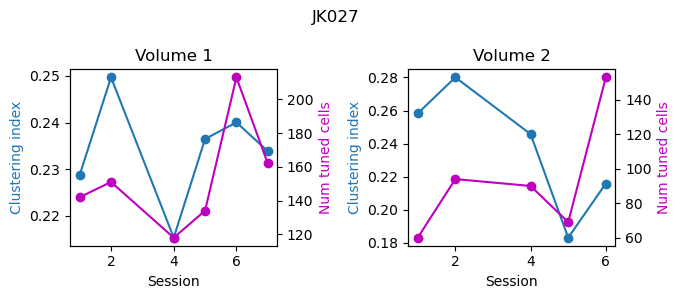

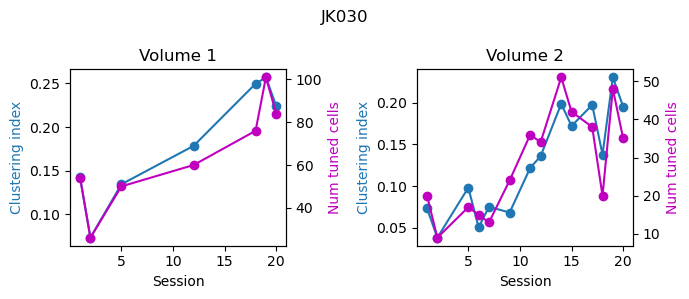

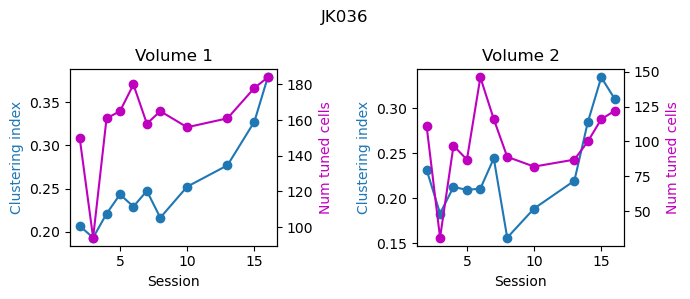

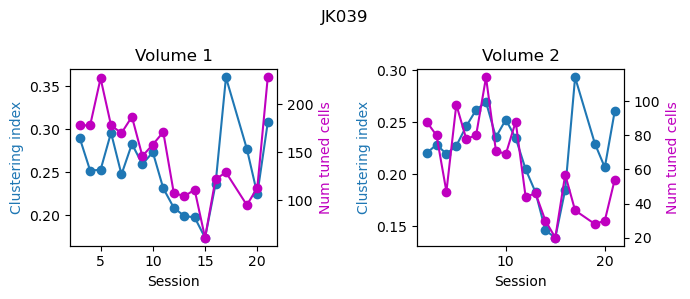

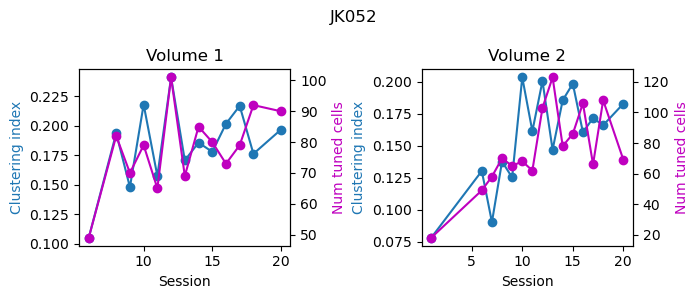

In [14]:
ind_cell_df['num_tuned_cells'] = ind_cell_df.apply(lambda x: len(np.intersect1d(x['ind_touch_glm'], x['ind_tuned_ttest_before_answer'])), axis=1)
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for volume in range(1,3):
        axi = volume - 1
        temp_df = clustering_index_df.query('mouse==@mouse and volume==@volume')
        ax[axi].plot(temp_df.session.values, temp_df.clustering_index.values, 
                     '-o', color='C0')
        ax[axi].set_xlabel('Session')
        ax[axi].set_ylabel('Clustering index', color='C0')
        ax[axi].set_title(f'Volume {volume}')
        axx = ax[axi].twinx()
        temp_df = ind_cell_df.query('mouse==@mouse and volume==@volume')
        axx.plot(temp_df.session.values, temp_df.num_tuned_cells.values, 
                 '-o', color='m')
        axx.set_ylabel('Num tuned cells', color='m')
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()

# Mean tuning amplitude vs CI

In [2]:

touch_dir = Path(r'C:\JK\results\touch_tuning')
touch_cell_fn = touch_dir / 'glm_vs_ttest_ind_cell_df.pkl'
ind_cell_df = pd.read_pickle(touch_cell_fn)

In [7]:
# gathering data

tuning_amp_df = pd.DataFrame(columns = ['mouse', 'volume', 'session', 'tuning_amp'])
pop_res_dir = results_dir / 'pop_responses/touch_before_answer'
for mouse in mice:
    for volume in range(1,3):
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]
        for session in sessions:
            touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
            touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
            tr = touch_response_results['per_touch_response_xr']
            tr_norm = (tr - tr.mean(axis=0)) / tr.std(axis=0)
            cid = ind_cell_df.query('mouse==@mouse and volume==@volume and session==@session').apply(lambda x:
                            np.intersect1d(x.ind_touch_glm, x.ind_tuned_ttest_before_answer), axis=1).values[0]
            cell_id_tuned = [f'p{str(id)[0]}c0{str(id)[1:]}' for id in cid]
            # cell_id_tuned = np.intersect1d(cell_id_tuned, tr_norm.cell_id) # This is necessary because some tuned cells were calculated from not touch cells 
            mean_45 = tr_norm.sel(trialNum=touch_response_results['per_touch_response_df'].query('pole_angle==45').trialNum.values).mean(axis=0)
            mean_135 = tr_norm.sel(trialNum=touch_response_results['per_touch_response_df'].query('pole_angle==135').trialNum.values).mean(axis=0)
            tuning_amp = [(mean_45 - mean_135).sel(cell_id=cell_id_tuned).values]
            temp_df = pd.DataFrame({'mouse': mouse, 'volume': volume, 'session': session,
                                    'tuning_amp': tuning_amp})
            tuning_amp_df = tuning_amp_df.append(temp_df)



In [10]:
clustering_index_dir = Path(r'C:\JK\results\neural_stretching\clustering_index')
clustering_index_fn = clustering_index_dir / 'clustering_index_training_before_touch_0.05_ptf_1.pkl'
clustering_index_df = pd.read_pickle(clustering_index_fn)

In [16]:
[np.mean(x) for x in np.abs(temp_df.tuning_amp.values)]

[0.9999559,
 0.6613002,
 0.82186496,
 0.79730725,
 0.970471,
 0.7943116,
 0.8936114,
 1.0415976]

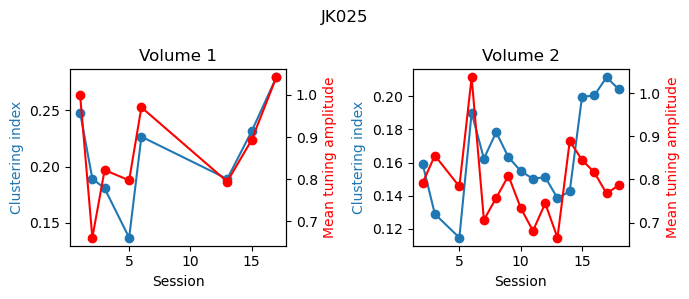

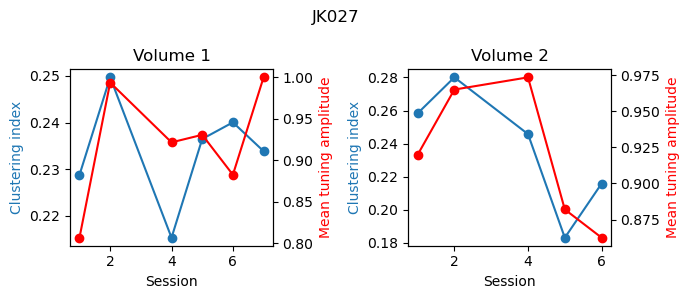

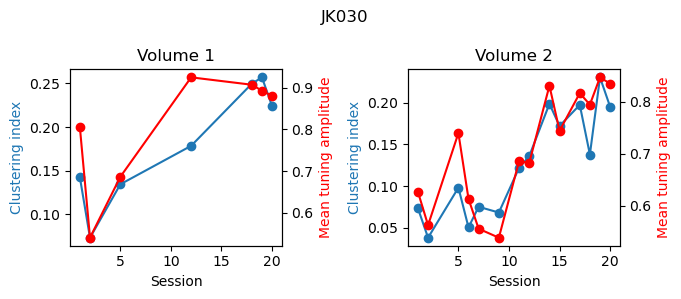

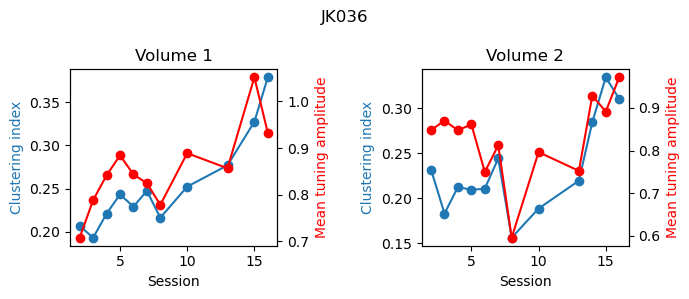

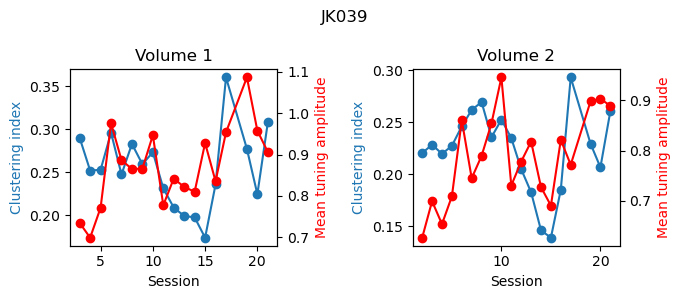

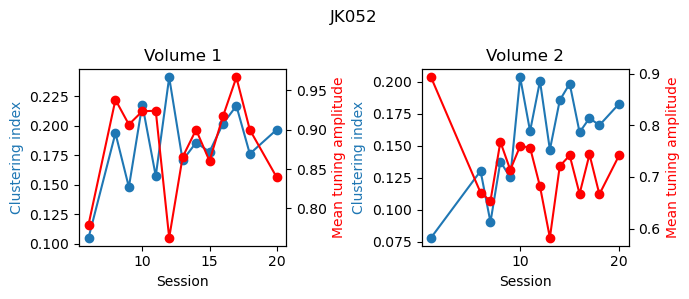

In [18]:
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for volume in range(1,3):
        axi = volume - 1
        temp_df = clustering_index_df.query('mouse==@mouse and volume==@volume')
        ax[axi].plot(temp_df.session.values, temp_df.clustering_index.values, 
                     '-o', color='C0')
        ax[axi].set_xlabel('Session')
        ax[axi].set_ylabel('Clustering index', color='C0')
        ax[axi].set_title(f'Volume {volume}')
        axx = ax[axi].twinx()
        temp_df = tuning_amp_df.query('mouse==@mouse and volume==@volume')
        axx.plot(temp_df.session.values, [np.mean(x) for x in np.abs(temp_df.tuning_amp.values)], 
                 '-o', color='r')
        axx.set_ylabel('Mean tuning amplitude', color='r')
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()

# Variance explained vs CI

In [11]:
clustering_index_dir = Path(r'C:\JK\results\neural_stretching\clustering_index')
clustering_index_fn = clustering_index_dir / 'clustering_index_training_before_touch_0.05_ptf_1.pkl'
clustering_index_df = pd.read_pickle(clustering_index_fn)

pca_dir = results_dir / 'neural_stretching/pca'
expvar_fn = pca_dir / 'expvar_0.05_ptf_1_touch_before_answer.pkl'
pca_expvar_df = pd.read_pickle(expvar_fn)



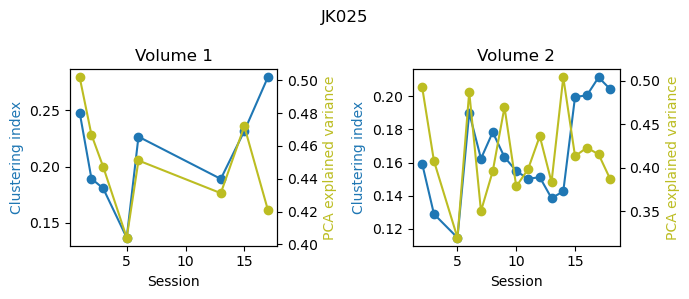

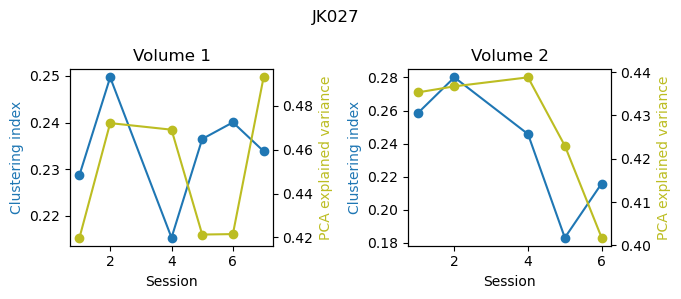

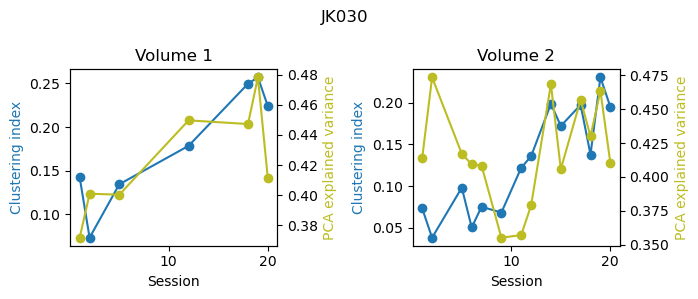

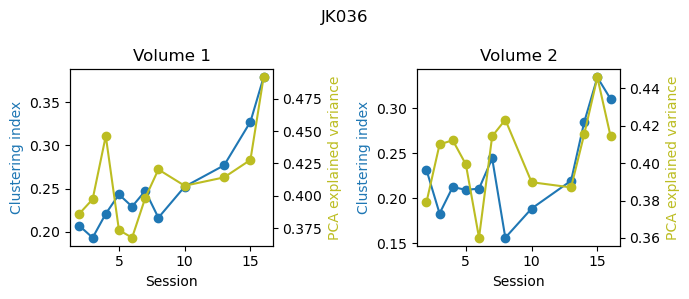

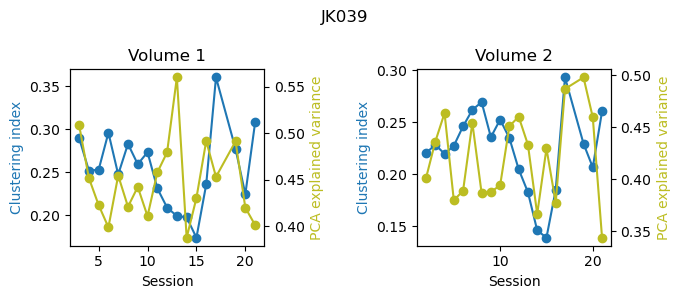

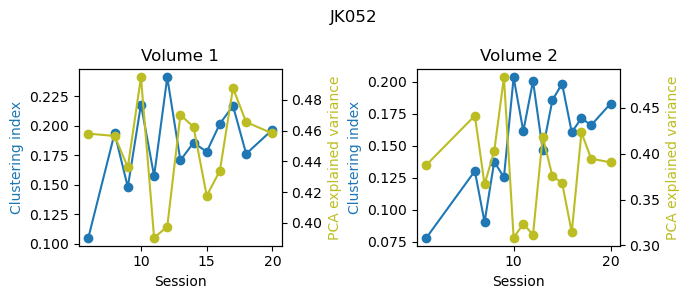

In [25]:
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for volume in range(1,3):
        axi = volume - 1
        temp_df = clustering_index_df.query('mouse==@mouse and volume==@volume')
        ax[axi].plot(temp_df.session.values, temp_df.clustering_index.values, 
                     '-o', color='C0')
        ax[axi].set_xlabel('Session')
        ax[axi].set_ylabel('Clustering index', color='C0')
        ax[axi].set_title(f'Volume {volume}')
        axx = ax[axi].twinx()
        temp_df = pca_expvar_df.query('mouse==@mouse and volume==@volume')
        axx.plot(temp_df.session.values, temp_df.exp_var.values, 
                 '-o', color='C8')
        axx.set_ylabel('PCA explained variance', color='C8')
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()

# CI with matched cells
- In another notebook (240428_clustering_index_matched_cells.ipynb)

# Rough division of learning phases and comparing clustering indices
- For now, based on session-wide performance and max(100)


In [21]:
naive_sessions = [range(1,11), range(1,5), range(1,15), range(1,7), range(1,8), range(1,15)]
learning_sessions = [range(11,15), range(5,6), range(15,19), range(7,14), range(8,16), range(15,17)]
expert_sessions = [range(15,19), range(6,8), range(19,21), range(14,17), range(16,22), range(17,21)]

clustering_index_dir = Path(r'C:\JK\results\neural_stretching\clustering_index')
clustering_index_fn = clustering_index_dir / 'clustering_index_training_before_touch_0.05_ptf_1.pkl'
clustering_index_df = pd.read_pickle(clustering_index_fn)


In [22]:
clustering_index_df

,mouse,volume,session,clustering_index,num_dim
0,25,1,1,0.248109,7
0,25,1,2,0.189396,7
0,25,1,3,0.180685,7
0,25,1,5,0.136879,7
0,25,1,6,0.226658,7
...,...,...,...,...,...
0,52,2,15,0.198407,7
0,52,2,16,0.160474,7
0,52,2,17,0.171534,7
0,52,2,18,0.165964,7


In [24]:
mean_cis = []
for mi, mouse in enumerate(mice):
    navie_session = naive_sessions[mi]
    learning_session = learning_sessions[mi]
    expert_session = expert_sessions[mi]
    for volume in range(1,3):
        naive_df = clustering_index_df.query('mouse==@mouse and volume==@volume and session in @navie_session')
        naive_ci = naive_df.clustering_index.mean()
        learning_df = clustering_index_df.query('mouse==@mouse and volume==@@volume and session in @learning_session')
        learning_ci = learning_df.clustering_index.mean()
        expert_df = clustering_index_df.query('mouse==@mouse and volume==@volume and session in @expert_session')
        expert_ci = expert_df.clustering_index.mean()
        mean_cis.append([naive_ci, learning_ci, expert_ci])
mean_cis = np.array(mean_cis)

Text(0, 0.5, 'Clustering index')

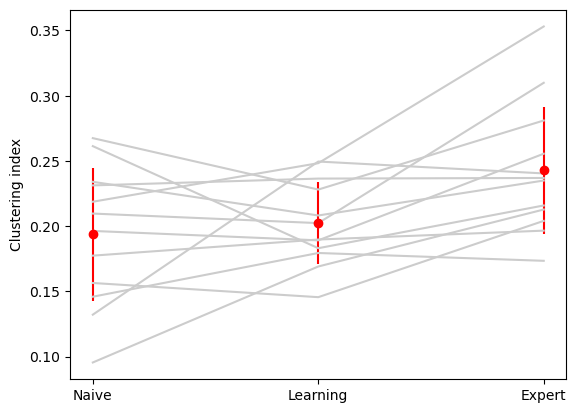

In [36]:
fig, ax = plt.subplots()
for i in range(mean_cis.shape[0]):
    ax.plot(mean_cis[i], '-', color=(0.8, 0.8, 0.8))
ax.errorbar(range(3), mean_cis.mean(axis=0), yerr=mean_cis.std(axis=0), fmt='o', color='r')
ax.set_xticks(range(3))
ax.set_xticklabels(['Naive', 'Learning', 'Expert'])
ax.set_ylabel('Clustering index')

In [44]:
# Run ANOVA
import scipy.stats as stats
print(stats.f_oneway(mean_cis[:,0], mean_cis[:,1], mean_cis[:,2]))
# RUn post-hoc
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(mean_cis.T.flatten(), np.repeat(['Naive', 'Learning', 'Expert'], 12))
result = mc.tukeyhsd()
print(result)

F_onewayResult(statistic=3.796736728847426, pvalue=0.032805939124869794)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  Expert Learning  -0.0405 0.0994 -0.0871  0.0062  False
  Expert    Naive   -0.049 0.0377 -0.0957 -0.0024   True
Learning    Naive  -0.0086 0.8945 -0.0552  0.0381  False
--------------------------------------------------------


In [48]:
# First 1/3 and last 1/3 of learning phase
mean_cis = []
for mi, mouse in enumerate(mice):
    navie_session = naive_sessions[mi]
    learning_session = learning_sessions[mi]
    expert_session = expert_sessions[mi]
    for volume in range(1,3):
        first_third = learning_session[:round(len(learning_session)/3)]
        last_third = learning_session[-round(len(learning_session)/3):]
        first_df = clustering_index_df.query('mouse==@mouse and volume==@volume and session in @first_third')
        first_ci = first_df.clustering_index.mean()
        last_df = clustering_index_df.query('mouse==@mouse and volume==@volume and session in @last_third')
        last_ci = last_df.clustering_index.mean()
        if len(first_df) == 0 or len(last_df) == 0:
            continue
        mean_cis.append([first_ci, last_ci])
mean_cis = np.array(mean_cis)

In [49]:
mean_cis

array([[0.1501474 , 0.14257948],
       [0.1720489 , 0.137842  ],
       [0.23190832, 0.27700302],
       [0.20045511, 0.21967099],
       [0.27171727, 0.1898792 ],
       [0.2525508 , 0.15606194],
       [0.17785339, 0.2016521 ],
       [0.19840668, 0.16047355]])

Text(0.5, 1.0, 'Naive sessions')

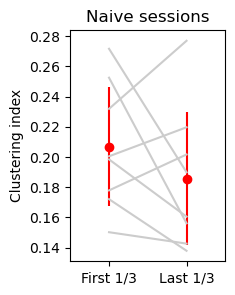

In [53]:
fig, ax = plt.subplots(figsize=(2,3))
for i in range(mean_cis.shape[0]):
    ax.plot(mean_cis[i], '-', color=(0.8, 0.8, 0.8))
ax.errorbar(range(2), mean_cis.mean(axis=0), yerr=mean_cis.std(axis=0), fmt='o', color='r')
ax.set_xticks(range(2))
ax.set_xticklabels(['First 1/3', 'Last 1/3'])
ax.set_xlim(-0.5, 1.5)
ax.set_ylabel('Clustering index')
ax.set_title('Naive sessions')


In [54]:
# t-test
print(stats.ttest_rel(mean_cis[:,0], mean_cis[:,1]))


Ttest_relResult(statistic=1.1836420619535435, pvalue=0.2751873624347621)


# Correlation of CI vs neuronal activity features
- Across all sessions 
- Within naive sessions only

## Num touch cells (GLM)

In [14]:
clustering_index_dir = Path(r'C:\JK\results\neural_stretching\clustering_index')
clustering_index_fn = clustering_index_dir / 'clustering_index_training_before_touch_0.05_ptf_1.pkl'
clustering_index_df = pd.read_pickle(clustering_index_fn)

touch_dir = Path(r'C:\JK\results\touch_tuning')
touch_cell_fn = touch_dir / 'glm_vs_ttest_ind_cell_df.pkl'
ind_cell_df = pd.read_pickle(touch_cell_fn)
ind_cell_df['num_touch_glm'] = ind_cell_df.apply(lambda x: len(x['ind_touch_glm']), axis=1)
ind_cell_df['num_tuned_cells'] = ind_cell_df.apply(lambda x: len(np.intersect1d(x['ind_touch_glm'], x['ind_tuned_ttest_before_answer'])), axis=1)

# gathering data for tuning amplitude
tuning_amp_df = pd.DataFrame(columns = ['mouse', 'volume', 'session', 'tuning_amp'])
pop_res_dir = results_dir / 'pop_responses/touch_before_answer'
for mouse in mice:
    for volume in range(1,3):
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]
        for session in sessions:
            touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
            touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
            tr = touch_response_results['per_touch_response_xr']
            tr_norm = (tr - tr.mean(axis=0)) / tr.std(axis=0)
            cid = ind_cell_df.query('mouse==@mouse and volume==@volume and session==@session').apply(lambda x:
                            np.intersect1d(x.ind_touch_glm, x.ind_tuned_ttest_before_answer), axis=1).values[0]
            cell_id_tuned = [f'p{str(id)[0]}c0{str(id)[1:]}' for id in cid]
            # cell_id_tuned = np.intersect1d(cell_id_tuned, tr_norm.cell_id) # This is necessary because some tuned cells were calculated from not touch cells 
            mean_45 = tr_norm.sel(trialNum=touch_response_results['per_touch_response_df'].query('pole_angle==45').trialNum.values).mean(axis=0)
            mean_135 = tr_norm.sel(trialNum=touch_response_results['per_touch_response_df'].query('pole_angle==135').trialNum.values).mean(axis=0)
            tuning_amp = [(mean_45 - mean_135).sel(cell_id=cell_id_tuned).values]
            temp_df = pd.DataFrame({'mouse': mouse, 'volume': volume, 'session': session,
                                    'tuning_amp': tuning_amp})
            tuning_amp_df = tuning_amp_df.append(temp_df)
tuning_amp_df['mean_abs_tuning_amp'] = tuning_amp_df.apply(lambda x: np.mean(np.abs(x.tuning_amp)), axis=1)

pca_dir = results_dir / 'neural_stretching/pca'
expvar_fn = pca_dir / 'expvar_0.05_ptf_1_touch_before_answer.pkl'
pca_expvar_df = pd.read_pickle(expvar_fn)

naive_sessions = [range(1,11), range(1,5), range(1,15), range(1,7), range(1,8), range(1,15)]
learning_sessions = [range(11,15), range(5,6), range(15,19), range(7,14), range(8,16), range(15,17)]
expert_sessions = [range(15,19), range(6,8), range(19,21), range(14,17), range(16,22), range(17,21)]

In [17]:
ci_corr_df = pd.DataFrame(columns=['mouse', 'volume', 'all_corr_num_touch', 'naive_corr_num_touch',
                                    'all_corr_num_tuned', 'naive_corr_num_tuned',
                                    'all_corr_tuning_amp', 'naive_corr_tuning_amp',
                                    'all_corr_pca_expvar', 'naive_corr_pca_expvar'])
for mi, mouse in enumerate(mice):
    for volume in range(1,3):
        ci_all_volume_df = clustering_index_df.query('mouse==@mouse and volume==@volume')
        ind_cell_volume_df = ind_cell_df.query('mouse==@mouse and volume==@volume')
        combined_df = pd.merge(ci_all_volume_df, ind_cell_volume_df, on=['session'])
        tuning_amp_volume_df = tuning_amp_df.query('mouse==@mouse and volume==@volume')
        combined_df = pd.merge(combined_df, tuning_amp_volume_df, on=['session'])
        pca_expvar_volume_df = pca_expvar_df.query('mouse==@mouse and volume==@volume')
        combined_df = pd.merge(combined_df, pca_expvar_volume_df, on=['session'])
        all_corr_num_touch = combined_df['clustering_index'].corr(combined_df['num_touch_glm'])
        all_corr_num_tuned = combined_df['clustering_index'].corr(combined_df['num_tuned_cells'])
        all_corr_tuning_amp = combined_df['clustering_index'].corr(combined_df['mean_abs_tuning_amp'])
        all_corr_pca_expvar = combined_df['clustering_index'].corr(combined_df['exp_var'])
        naive_session = naive_sessions[mi]
        naive_df = combined_df.query('session in @naive_session')
        naive_corr_num_touch = naive_df['clustering_index'].corr(naive_df['num_touch_glm'])
        naive_corr_num_tuned = naive_df['clustering_index'].corr(naive_df['num_tuned_cells'])
        naive_corr_tuning_amp = naive_df['clustering_index'].corr(naive_df['mean_abs_tuning_amp'])
        naive_corr_pca_expvar = naive_df['clustering_index'].corr(naive_df['exp_var'])
        temp_df = pd.DataFrame({'mouse': mouse, 'volume': volume,
                                'all_corr_num_touch': all_corr_num_touch, 'naive_corr_num_touch': naive_corr_num_touch,
                                'all_corr_num_tuned': all_corr_num_tuned, 'naive_corr_num_tuned': naive_corr_num_tuned,
                                'all_corr_tuning_amp': all_corr_tuning_amp, 'naive_corr_tuning_amp': naive_corr_tuning_amp,
                                'all_corr_pca_expvar': all_corr_pca_expvar, 'naive_corr_pca_expvar': naive_corr_pca_expvar},
                                index=[0])
        ci_corr_df = ci_corr_df.append(temp_df)
        


C:\Users\shires\AppData\Local\Temp/ipykernel_24660/1778402947.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'volume_x', 'mouse_x'} in the result is deprecated and will raise a MergeError in a future version.
  combined_df = pd.merge(combined_df, pca_expvar_volume_df, on=['session'])


Text(0, 0.5, 'Correlation')

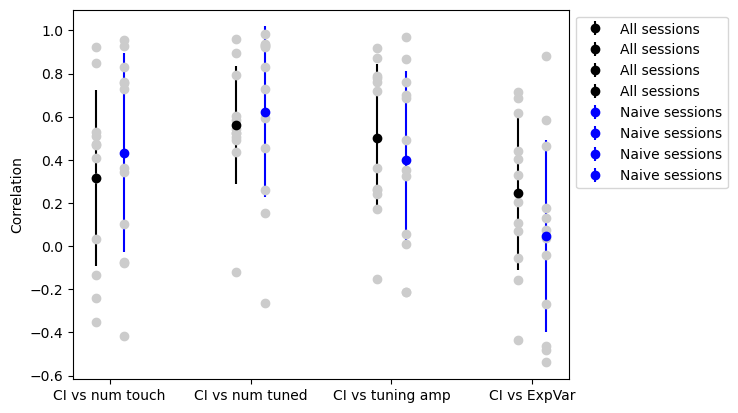

In [34]:
fig, ax = plt.subplots()
all_column_names = ['all_corr_num_touch', 'all_corr_num_tuned', 'all_corr_tuning_amp', 'all_corr_pca_expvar']
naive_column_names = ['naive_corr_num_touch', 'naive_corr_num_tuned', 'naive_corr_tuning_amp', 'naive_corr_pca_expvar']
for i, column_name in enumerate(all_column_names):
    ax.plot(np.ones(12)*i-0.1, ci_corr_df[column_name], 'o', color=np.ones(3)*0.8)
    ax.errorbar(i-0.1, ci_corr_df[column_name].mean(), yerr=ci_corr_df[column_name].std(), fmt='o', color='k', label='All sessions')
for i, column_name in enumerate(naive_column_names):
    ax.plot(np.ones(12)*i+0.1, ci_corr_df[column_name], 'o', color=np.ones(3)*0.8)
    ax.errorbar(i+0.1, ci_corr_df[column_name].mean(), yerr=ci_corr_df[column_name].std(), fmt='o', color='b', label='Naive sessions')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set_xticks(range(4))
ax.set_xticklabels(['CI vs num touch', 'CI vs num tuned', 'CI vs tuning amp', 'CI vs ExpVar'])
ax.set_ylabel('Correlation')

# Look at within-volume ci variation vs neuronal activity parameters
- Average touch encoding
- Num tuned cell
- Tuning amplitude
- Exp variance
- From randomly selecting different number of neurons

In [74]:
def clustering_index_vs_neuronal_activity(mouse, volume, session,
                                   num_dim=7,
                                   angles=None,
                                   pca_specific=True, # when using subset of angles (e.g., 
                                    # 45 and 135 from test sessions)
                                   num_trials_choose=30, #
                                #    num_cells_choose=75, # 
                                   rand_cell_prop_range = (1/3, 5/6), 
                                   num_repeat=500,
                                   num_shuffle_trials=100):
    ''' 
    Always balance trials between angles.
    Intended to use with fit cells only.
    rand_cell_prop_range: range of random cell proportion to choose from

    '''
    planes = range(1,5) if volume==1 else range(5,9)

    touch_dir = Path(r'C:\JK\results\touch_tuning')
    touch_cell_fn = touch_dir / 'glm_vs_ttest_ind_cell_df.pkl'
    ind_cell_df = pd.read_pickle(touch_cell_fn)
    ind_cell_df['num_touch_glm'] = ind_cell_df.apply(lambda x: len(x['ind_touch_glm']), axis=1)
    ind_cell_df['num_tuned_cells'] = ind_cell_df.apply(lambda x: len(np.intersect1d(x['ind_touch_glm'], x['ind_tuned_ttest_before_answer'])), axis=1)

    touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
    touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
    response_xr = touch_response_results['per_touch_response_xr_fit']
    response_df = touch_response_results['per_touch_response_df']

    glm_dir = Path(r'C:\JK\results\neuron_glm\ridge\touch_combined')
    for pi, plane in enumerate(planes):
        glm_fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
        with xr.open_dataset(glm_fn) as glm_result:
            glm_result.load()
        cell_id_str = [f'p{plane}c{id:04}' for id in glm_result.cell_id.values]
        glm_result = glm_result.assign_coords(cell_id=cell_id_str)
        touch_encoding = glm_result.varexp_drop.sel(dropped_feature='touch')
        if pi==0:
            touch_encoding_all = touch_encoding
        else:
            touch_encoding_all = xr.concat([touch_encoding_all, touch_encoding], dim='cell_id')

    if angles is None:
        angles = np.unique(response_df.pole_angle)
    else:
        exist_inds = np.where(np.isin(angles, np.unique(response_df.pole_angle)))[0]
        angles = angles[exist_inds]
    if pca_specific:
        response_df = response_df.query('pole_angle in @angles')
        angle_tns = response_df.trialNum.values
        response_xr = response_xr.sel(trialNum=angle_tns)
    # Standardize touch response
    tr_norm = (response_xr - response_xr.mean(axis=0)) / response_xr.std(axis=0)

    # Set empty dataframe
    clustering_index_repeats = pd.DataFrame(columns=['clustering_index', 'mean_touch_encoding',
    'num_tuned_cells', 'mean_tuning_amplitude', 'exp_var'])

    num_cells = tr_norm.cell_id.size

    for ri in range(num_repeat):
        rand_prop = np.random.random() * (rand_cell_prop_range[1] - rand_cell_prop_range[0]) + \
                    rand_cell_prop_range[0]
        num_cells_choose = np.round(num_cells * rand_prop).astype(int)
        # randomly choosing cells
        inds = np.random.choice(num_cells, num_cells_choose, replace=False)
        cell_ids = tr_norm.cell_id[inds]
        tr_norm_sub = tr_norm.sel(cell_id=cell_ids)

        # mean touch encoding
        mean_touch_encoding = touch_encoding_all.sel(cell_id=cell_ids).mean().values 

        # num tuned cells
        cid = ind_cell_df.query('mouse==@mouse and volume==@volume and session==@session').apply(lambda x:
                                np.intersect1d(x.ind_touch_glm, x.ind_tuned_ttest_before_answer), axis=1).values[0]
        cell_id_tuned = [f'p{str(id)[0]}c0{str(id)[1:]}' for id in cid]
        cell_id_tuned = np.intersect1d(cell_id_tuned, tr_norm_sub.cell_id)
        num_tuned_cells = len(cell_id_tuned)

        # mean tuning amplitude from tuned cells
        if num_tuned_cells > 0:
            mean_45 = tr_norm_sub.sel(trialNum=response_df.query('pole_angle==45').trialNum.values,
                                    cell_id=cell_id_tuned).mean(dim='trialNum')
            mean_135 = tr_norm_sub.sel(trialNum=response_df.query('pole_angle==135').trialNum.values,
                                        cell_id=cell_id_tuned).mean(dim='trialNum')
            mean_tuning_amplitude = np.abs(mean_45 - mean_135).mean().values
        else:
            mean_tuning_amplitude = 0

        pca = PCA()
        pca.fit(tr_norm_sub)

        # Exp var
        exp_var = np.cumsum(pca.explained_variance_ratio_)[num_dim-1]

        pc_all_angles = []
        for ai, angle in enumerate(angles):
            angle_tns = response_df[response_df.pole_angle==angle].trialNum.values
            responses_angle = tr_norm_sub.sel(trialNum=angle_tns)
            pc = pca.transform(responses_angle)
            pc_all_angles.append(pc)
        num_groups = len(angles)

        clustering_index_trial = []
        for gi in range(num_groups):
            this_group = pc_all_angles[gi]
            other_group = np.concatenate([pc_all_angles[i] for i in range(num_groups) if i!=gi])
            within_group_dist = squareform(pdist(this_group[:, :num_dim], 'euclidean'))
            between_group_dist = cdist(this_group[:, :num_dim], other_group[:, :num_dim], 'euclidean')
            
            num_within_group = this_group.shape[0]
            num_between_group = other_group.shape[0]
            for i in range(num_shuffle_trials):
                # within_group_inds = np.random.choice(num_within_group-1, num_trials_choose, replace=False)
                # between_group_inds = np.random.choice(num_between_group-1, num_trials_choose, replace=False)
                within_group_inds = np.random.choice(num_within_group, num_trials_choose, replace=False)
                between_group_inds = np.random.choice(num_between_group, num_trials_choose, replace=False)
                within_group_dist_temp = within_group_dist[within_group_inds, :][:, within_group_inds]
                between_group_dist_temp = between_group_dist[within_group_inds, :][:, between_group_inds]
                clustering_index_repeat = []
                for ti in range(num_trials_choose):
                    within_group_mean = within_group_dist_temp[ti,:].sum() / (num_trials_choose-1)
                    between_group_mean = between_group_dist_temp[ti,:].mean()
                    clustering_index_repeat.append((between_group_mean - within_group_mean) / (between_group_mean + within_group_mean))
                clustering_index_trial.append(np.mean(clustering_index_repeat))
        clustering_index_repeats = clustering_index_repeats.append({'clustering_index': np.mean(clustering_index_trial),
                                                                    'mean_touch_encoding': mean_touch_encoding,
                                                                    'num_tuned_cells': num_tuned_cells,
                                                                    'mean_tuning_amplitude': mean_tuning_amplitude.astype(float),
                                                                    'exp_var': exp_var}, ignore_index=True)
    clustering_index_repeats.mean_touch_encoding = clustering_index_repeats.mean_touch_encoding.astype(float)
    clustering_index_repeats.mean_tuning_amplitude = clustering_index_repeats.mean_tuning_amplitude.astype(float)
    clustering_index_repeats.num_tuned_cells = clustering_index_repeats.num_tuned_cells.astype(float)
        
    return clustering_index_repeats

In [ ]:
save_dir = results_dir / 'clustering_index_vs_neuronal_activity_within_volume'
for mouse in mice:
    for volume in range(1,3):
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]
        for session in sessions:
            clustering_index_vs_df = clustering_index_vs_neuronal_activity(mouse, volume, session)
            save_fn = save_dir / f'JK{mouse:03}S{session:02}_volume_{volume}_clustering_index_vs_neuronal_activity_within_volume.pkl'
            clustering_index_vs_df.to_pickle(save_fn)

In [75]:
num_fit_cells = []
for mouse in mice:
    for volume in range(1,3):
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]
        for session in sessions:
            touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
            touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
            response_xr = touch_response_results['per_touch_response_xr_fit']
            num_fit_cells.append(response_xr.cell_id.size)

(array([ 7., 26., 19., 22., 26., 17., 15.,  7.,  3.,  2.]),
 array([ 37. ,  76.3, 115.6, 154.9, 194.2, 233.5, 272.8, 312.1, 351.4,
        390.7, 430. ]),
 <BarContainer object of 10 artists>)

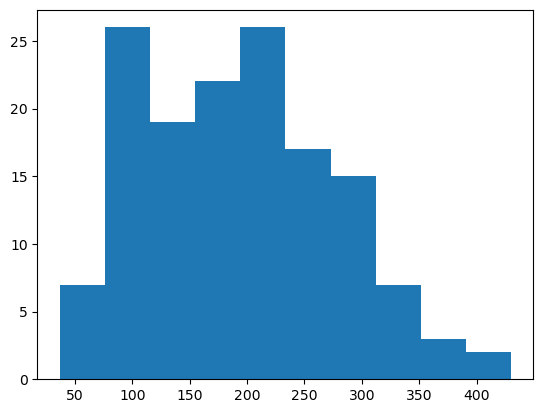

In [77]:
plt.hist(num_fit_cells)

# Run this in multiprocessing

In [5]:
touch_dir = Path(r'C:\JK\results\touch_tuning')
touch_cell_fn = touch_dir / 'glm_vs_ttest_ind_cell_df.pkl'
ind_cell_df = pd.read_pickle(touch_cell_fn)
ind_cell_df['num_touch_glm'] = ind_cell_df.apply(lambda x: len(x['ind_touch_glm']), axis=1)
ind_cell_df['num_tuned_cells'] = ind_cell_df.apply(lambda x: len(np.intersect1d(x['ind_touch_glm'], x['ind_tuned_ttest_before_answer'])), axis=1)


In [14]:
mouse = 25
volume = 1
planes = range(1,5) if volume==1 else range(5,9)
session = 1

touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
response_xr = touch_response_results['per_touch_response_xr_fit']
response_df = touch_response_results['per_touch_response_df']

glm_dir = Path(r'C:\JK\results\neuron_glm\ridge\touch_combined')
for pi, plane in enumerate(planes):
    glm_fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
    with xr.open_dataset(glm_fn) as glm_result:
        glm_result.load()
    cell_id_str = [f'p{plane}c{id:04}' for id in glm_result.cell_id.values]
    glm_result = glm_result.assign_coords(cell_id=cell_id_str)
    touch_encoding = glm_result.varexp_drop.sel(dropped_feature='touch')
    if pi==0:
        touch_encoding_all = touch_encoding
    else:
        touch_encoding_all = xr.concat([touch_encoding_all, touch_encoding], dim='cell_id')
    



In [49]:
angles=None
pca_specific=False
num_repeat=200
num_shuffle_trials=100
num_trials_choose=30
num_dim = 7
num_cells_choose = 75

if angles is None:
    angles = np.unique(response_df.pole_angle)
else:
    exist_inds = np.where(np.isin(angles, np.unique(response_df.pole_angle)))[0]
    angles = angles[exist_inds]
if pca_specific:
    response_df = response_df.query('pole_angle in @angles')
    angle_tns = response_df.trialNum.values
    response_xr = response_xr.sel(trialNum=angle_tns)
# Standardize touch response
tr_norm = (response_xr - response_xr.mean(axis=0)) / response_xr.std(axis=0)

# Set empty dataframe    
clustering_index_repeats = pd.DataFrame(columns=['clustering_index', 'mean_touch_encoding',
'num_tuned_cells', 'mean_tuning_amplitude', 'exp_var'])

num_cells = tr_norm.cell_id.size

for ri in range(num_repeat):
    # randomly choosing cells
    inds = np.random.choice(num_cells, num_cells_choose, replace=False)
    cell_ids = tr_norm.cell_id[inds]
    tr_norm_sub = tr_norm.sel(cell_id=cell_ids)

    # mean touch encoding
    mean_touch_encoding = touch_encoding_all.sel(cell_id=cell_ids).mean().values 

    # num tuned cells
    cid = ind_cell_df.query('mouse==@mouse and volume==@volume and session==@session').apply(lambda x:
                            np.intersect1d(x.ind_touch_glm, x.ind_tuned_ttest_before_answer), axis=1).values[0]
    cell_id_tuned = [f'p{str(id)[0]}c0{str(id)[1:]}' for id in cid]
    cell_id_tuned = np.intersect1d(cell_id_tuned, tr_norm_sub.cell_id)
    num_tuned_cells = len(cell_id_tuned)

    # mean tuning amplitude from tuned cells
    mean_45 = tr_norm_sub.sel(trialNum=response_df.query('pole_angle==45').trialNum.values,
                              cell_id=cell_id_tuned).mean(dim='trialNum')
    mean_135 = tr_norm_sub.sel(trialNum=response_df.query('pole_angle==135').trialNum.values,
                                cell_id=cell_id_tuned).mean(dim='trialNum')
    mean_tuning_amplitude = np.abs(mean_45 - mean_135).mean().values

    pca = PCA()
    pca.fit(tr_norm_sub)

    # Exp var
    exp_var = np.cumsum(pca.explained_variance_ratio_)[num_dim-1]

    pc_all_angles = []
    for ai, angle in enumerate(angles):
        angle_tns = response_df[response_df.pole_angle==angle].trialNum.values
        responses_angle = tr_norm_sub.sel(trialNum=angle_tns)
        pc = pca.transform(responses_angle)
        pc_all_angles.append(pc)
    num_groups = len(angles)

    clustering_index_trial = []
    for gi in range(num_groups):
        this_group = pc_all_angles[gi]
        other_group = np.concatenate([pc_all_angles[i] for i in range(num_groups) if i!=gi])
        within_group_dist = squareform(pdist(this_group[:, :num_dim], 'euclidean'))
        between_group_dist = cdist(this_group[:, :num_dim], other_group[:, :num_dim], 'euclidean')
        
        num_within_group = this_group.shape[0]
        num_between_group = other_group.shape[0]
        for i in range(num_shuffle_trials):
            # within_group_inds = np.random.choice(num_within_group-1, num_trials_choose, replace=False)
            # between_group_inds = np.random.choice(num_between_group-1, num_trials_choose, replace=False)
            within_group_inds = np.random.choice(num_within_group, num_trials_choose, replace=False)
            between_group_inds = np.random.choice(num_between_group, num_trials_choose, replace=False)
            within_group_dist_temp = within_group_dist[within_group_inds, :][:, within_group_inds]
            between_group_dist_temp = between_group_dist[within_group_inds, :][:, between_group_inds]
            clustering_index_repeat = []
            for ti in range(num_trials_choose):
                within_group_mean = within_group_dist_temp[ti,:].sum() / (num_trials_choose-1)
                between_group_mean = between_group_dist_temp[ti,:].mean()
                clustering_index_repeat.append((between_group_mean - within_group_mean) / (between_group_mean + within_group_mean))
            clustering_index_trial.append(np.mean(clustering_index_repeat))
    clustering_index_repeats = clustering_index_repeats.append({'clustering_index': np.mean(clustering_index_trial),
                                                                'mean_touch_encoding': mean_touch_encoding,
                                                                'num_tuned_cells': num_tuned_cells,
                                                                'mean_tuning_amplitude': mean_tuning_amplitude.astype(float),
                                                                'exp_var': exp_var}, ignore_index=True)
clustering_index_repeats.mean_touch_encoding = clustering_index_repeats.mean_touch_encoding.astype(float)
clustering_index_repeats.mean_tuning_amplitude = clustering_index_repeats.mean_tuning_amplitude.astype(float)
clustering_index_repeats.num_tuned_cells = clustering_index_repeats.num_tuned_cells.astype(float)

In [50]:
clustering_index_repeats

,clustering_index,mean_touch_encoding,num_tuned_cells,mean_tuning_amplitude,exp_var
0,0.198863,0.10272071654478424,35,0.9795677,0.581343
1,0.235977,0.08916888696366757,33,1.0353435,0.512704
2,0.208424,0.09000573607736694,27,1.0137205,0.540914
3,0.210899,0.09087386631590122,28,0.9997471,0.525271
4,0.219781,0.08735623073036893,34,1.0089277,0.550195
...,...,...,...,...,...
195,0.213664,0.0935923488534959,33,0.94208395,0.568609
196,0.213340,0.08800979759449491,32,1.0148463,0.531523
197,0.216072,0.1026354584656967,36,0.99731106,0.577075
198,0.191267,0.09077568401646254,30,1.0245545,0.550407


In [61]:
clustering_index_repeats.clustering_index.corr(clustering_index_repeats.exp_var)

0.31327358356808804